# Location Classification
The goal of this notebook is to find important lab tests per location of (positive) uveitis patients. 
The hypothesis is that an anterior inflammation can be identified by a different subset of lab tests as for example posterior inflammations. 
This would allow to order a subset of all possible lab tests after the location of the inflammation has been located to identify uveitis. One approach would be to train a model per location.

Steps:

1. Get Subset of Data (Target Featue: Location, Input Features: Lab Results) 
2. Define suitable Algorithms for Binary Classification (e.g. Logistic Regression, etc.)
3. Call preprocessing pipe with appropriat parameters for the current algorithm
4. Fit Model
5. Extract and Discuss important Features

In [110]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn standard imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Binarizer, LabelEncoder, Normalizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# !pip install scikit-optimize # = skopt
from skopt import BayesSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, f1_score, precision_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from dtreeviz.trees import dtreeviz
from sklearn.metrics import plot_confusion_matrix


# import of pipe module
os.chdir('../preprocessing/')
import pipe

os.chdir('../machine_learning/')
import helpers


RANDOM = 43
SCORER = make_scorer(f1_score, average='macro')
def SCORE(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')


def get_feature_names(pipeline_object):
    num_feat = pipeline_object[0].transformers_[0][2]
    one_hot_feat = pipeline_object[0].transformers_[1][1]['onehot'].get_feature_names(categorical_features)
    return list(num_feat) + list(one_hot_feat)

def plot_featureimportance(pipeline_object):
    a = pd.DataFrame()
    a['value'] = pipeline_object[1].feature_importances_
    a['feature'] = get_feature_names(pipeline_object)
    a = a.sort_values(by='value', ascending=False)
    plt.figure(figsize=(10,7))
    g = sns.barplot(y=a.feature, x=a.value*100, data= a, color = 'steelblue')
    helpers.plot_wrapper(g, 'Feature Importances', None, 'Percentage', 'Feature Name')

## Data Preparation
To predict the location of an inflammation, we need to drop all columns that contain information about the location. Meta-Information about the patient will also be dropped.

In [111]:
# calling preprocessing function

# num_to_cat = True: Range Date is now dtype Category 
# drop_filter: Drop every column that is not a lab test

df = pipe.preprocessing_pipe(num_to_cat   = False,
                             drop_filter  = ['hla', 'ac_', 'vit_','race', 'cat','specific_diagnosis'],
                             loc_approach = 'multi',
                             binary_cat   = True,
                             nan_percentage = 0.2,
                             hot_encode_cat = True) 
df.head()

,gender,loc,calcium,lactate_dehydrogenase,"c-reactive_protein,_normal_and_high_sensitivity",wbc,rbc,hemoglobin,hematocrit,mcv,...,"lysozyme,_plasma",anti-ccp_ab,anti-ena_screen,antinuclear_antibody,dna_double-stranded_ab,rheumatoid_factor,hbc__ab,hbs__ag,hcv__ab,uveitis
0,Male,anterior,2.27,184,1.83,6.91,4.97,14.6,41.4,83.3,...,3.0,0.0,0.0,0.0,0.0,0,0,0,0,False
1,Female,intermediate,2.32,209,0.15,4.24,4.22,11.0,36.0,85.3,...,<NA>,0.0,0.0,0.0,0.0,0,0,0,0,True
2,Female,panuveitis,2.44,194,0.137,6.38,4.31,13.6,38.7,89.8,...,4.8,0.0,0.0,0.0,0.0,0,0,0,0,True
3,Female,anterior,2.45,156,3.5,5.24,4.82,14.6,43.6,90.5,...,<NA>,0.0,0.0,0.0,0.0,0,0,0,0,True
4,Female,anterior,2.28,175,1.0,8.31,4.72,14.0,40.7,86.2,...,4.5,0.0,0.0,0.0,1.0,0,0,0,0,True


### Split into uveitis and not_uveitis data

In [112]:
df_uv_pos = df[df.uveitis == True]
df_uv_neg = df[df.uveitis != True]

# Multiclass classification
In this section we try to predict the location of an inflammation of uveitis positive patients. For this we remove records of non uveitis patients.
These models can be used as a comparison for the binary classification (see next chapter)

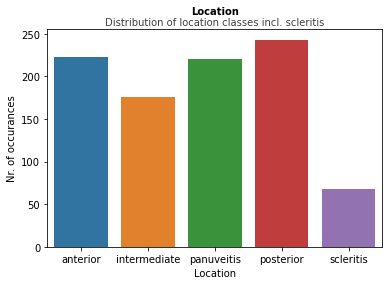

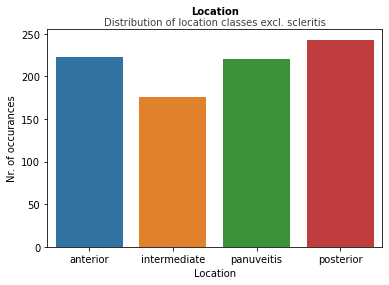

In [113]:
df_uv_pos_clean = df_uv_pos.dropna(subset=['loc']) # drop records with missing location data (3)


g = sns.countplot(x=df_uv_pos_clean['loc'])
helpers.plot_wrapper(g, 'Location','Distribution of location classes incl. scleritis','Location','Nr. of occurances')

# remove category scleritis
df_uv_pos_clean = df_uv_pos_clean[df_uv_pos_clean['loc'] != 'scleritis']
df_uv_pos_clean['loc'] = df_uv_pos_clean['loc'].cat.remove_unused_categories()

g = sns.countplot(x=df_uv_pos_clean['loc'])
helpers.plot_wrapper(g, 'Location','Distribution of location classes excl. scleritis','Location','Nr. of occurances')

**Discussion** The target feature contains 5 classes. The three missing values have been removed. We can see that, with the execption of the location 'scleritis', that the classes are somewhat balanced. We remove the records with location 'scleritis' as upsampling or downsampling is not an option for this dataset. Because it is a minority class, it can negatively impact the prediction for every other class.

#### Train-Test Split
Trainingset contains 75% of data. The target feature is the loc (Location)-Feature. 
The target feature contains 3 missing values. We initially drop these records.

We pose the hypothesis that splitting the data into a male and female subset yields better results for the machine learning algorithmns. Thus we create 3 datasets. One containing all records with uveitits `X`, one containing only the male data `X_m` (the `m` stands for "male") and one containing only the female data `X_f` (the `f`stands for "female")

In [114]:
# train_test_split
X = df_uv_pos_clean.drop(columns=['loc','uveitis','gender'])
y = df_uv_pos_clean['loc']

X_m = df_uv_pos_clean[df_uv_pos_clean.gender == 'Male'].drop(columns=['loc','uveitis','gender'])
X_f = df_uv_pos_clean[df_uv_pos_clean.gender == 'Female'].drop(columns=['loc','uveitis','gender'])
y_m = df_uv_pos_clean[df_uv_pos_clean.gender == 'Male']['loc']
y_f = df_uv_pos_clean[df_uv_pos_clean.gender == 'Female']['loc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM, stratify = y)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.25, random_state=RANDOM, stratify = y_m)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.25, random_state=RANDOM, stratify = y_f)

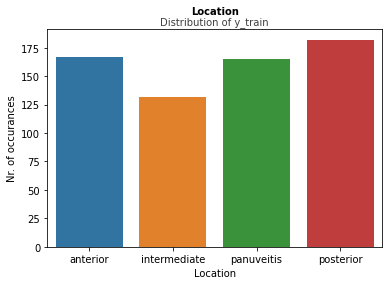

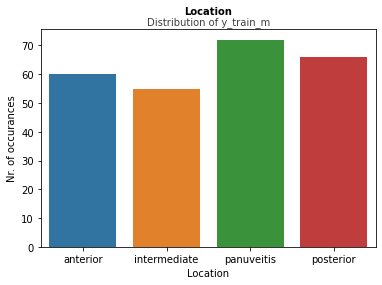

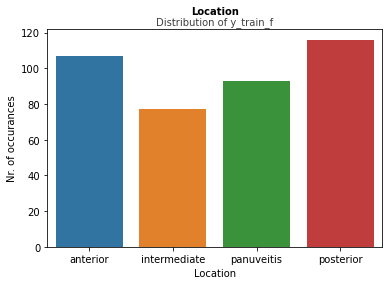

In [115]:
g = sns.countplot(x=y_train)
helpers.plot_wrapper(g, 'Location','Distribution of y_train','Location','Nr. of occurances')
g = sns.countplot(x=y_train_m)
helpers.plot_wrapper(g, 'Location','Distribution of y_train_m','Location','Nr. of occurances')
g = sns.countplot(x=y_train_f)
helpers.plot_wrapper(g, 'Location','Distribution of y_train_f','Location','Nr. of occurances')

**Discussion** The three countplots show the distribution of the target feature for after the train-test Split for the whole dataset and the male/female datasets.

#### Imputation and Encoding

In [116]:
# filter for numeric and categorical features
numerics = ['Int64','float64']
category = ['category','bool']

# select list of numeric and categorical features
numeric_features = X.select_dtypes(include=numerics).columns.tolist()
categorical_features = X.select_dtypes(include=category).columns.tolist()

# define imputer strategy (consult sklarn SimpleImputer and StandardScaler documentation for options)
imputer = {'categorical':{'strategy':'most_frequent','fill_value':'most_frequent'}, 'numerical':{'strategy':'median', 'fill_value':'mean'}}
imputer_encoder_no_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False)
imputer_encoder_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=False)
imputer_encoder_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=True)
imputer_encoder_no_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False, knn_impute=True)

USE_IMPUTER = imputer_encoder_onehot # imputer_encoder_onehot yields best results so far 

We test multiple strategies for imputing missing values and encoding the data for later use with machine learning algorithms:

1. No OneHotEncoding of categorical features, categories will be Label Encoded. (with LabelEncoder), strategy for imputation: 
    Categorical Features: Most Frequent, Numerical Features: Median value.
2. OneHotEncoding of categorical features, strategy for imputation:
    Same as in Number 1
3. OneHotEncoding and imputation of missing values with a KNN Algorithmn.
4. No OneHotEncoding and imputation of missing values with a KNN Algorithmn.

## 3-Dimensional Data Representation

In [117]:
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train.values,
                   title="PCA representation of uveitits positive training data", labels={"0":"PC1","1":"PC2","2":"PC3"}, opacity=1,
                   width=800, height=800, size_max=.5)
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.53 %


In [118]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_m)

fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_m.values,
                   title="PCA representation of uveitits positive training data (male only)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 40.49 %


In [119]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_f)

fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_f.values,
                   title="PCA representation of uveitits positive training data (female only)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 40.1 %


The graphics above represent all three datasets in the first 3 Principal Components. We retain about 40% of the variance for all 3 datasets. We see hardly any distinguishable clusters in the data. It seems that the data will be hard to classify.

## Baseline Model
This model acts as our basline. This model takes in the prior probability of a class occuring in the trainingset, and recommends blindly based on these probabilites. 
### Complete positive data

In [120]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train, y_train)
print(f'Score Dummy Classifier: {SCORE(y_test, pipeline.predict(X_test))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.24274361259655375
Class probabilites: [0.25851393 0.20433437 0.25541796 0.28173375]


### Male positive data

In [121]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train_m, y_train_m)
print(f'Score Dummy Classifier: {SCORE(y_test_m, pipeline.predict(X_test_m))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.32811653116531164
Class probabilites: [0.23715415 0.2173913  0.28458498 0.26086957]


### Female positive data

In [122]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train_f, y_train_f)
print(f'Score Dummy Classifier: {SCORE(y_test_f, pipeline.predict(X_test_f))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.2549411286113414
Class probabilites: [0.27226463 0.19592875 0.23664122 0.29516539]


## Decision Tree

### Complete positive data

Score: 0.25944485842026827
Best Parameters:
{'tree__class_weight': 'balanced', 'tree__criterion': 'gini', 'tree__max_depth': 8, 'tree__min_samples_split': 12, 'tree__random_state': 43, 'tree__splitter': 'random'}
              precision    recall  f1-score   support

    anterior       0.31      0.30      0.31        56
intermediate       0.22      0.39      0.28        44
  panuveitis       0.24      0.11      0.15        55
   posterior       0.31      0.30      0.30        61

    accuracy                           0.27       216
   macro avg       0.27      0.27      0.26       216
weighted avg       0.27      0.27      0.26       216

Standarddeviation Score: 0.02801316549712626


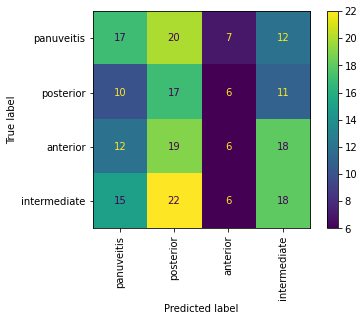

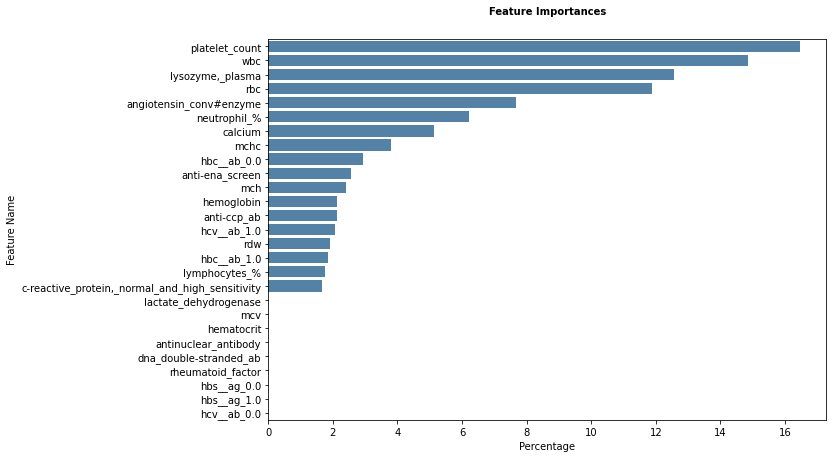

In [123]:
# supress warnings of estimator fit failed
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def dec_tree(X_train, X_test, y_train, y_test):
    dectree = DecisionTreeClassifier(random_state=RANDOM)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('tree', dectree)
    ])

    # hyperparameterspace
    parameters = {
        'tree__criterion':['gini','entropy'],
        'tree__splitter' :['best','random'],
        'tree__max_depth':np.arange(2,20,2),
        'tree__min_samples_split':[int(i) for i in np.arange(2,20,10)],
        'tree__random_state':[RANDOM],
        'tree__class_weight':['balanced', None] # balanced = inverse proportional importance per class
    }

    # grid search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    plot_featureimportance(bv.best_estimator_)

dec_tree(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.295022412878148
Best Parameters:
{'tree__class_weight': 'balanced', 'tree__criterion': 'gini', 'tree__max_depth': 4, 'tree__min_samples_split': 2, 'tree__random_state': 43, 'tree__splitter': 'best'}
              precision    recall  f1-score   support

    anterior       0.33      0.25      0.29        20
intermediate       0.25      0.32      0.28        19
  panuveitis       0.31      0.46      0.37        24
   posterior       0.36      0.18      0.24        22

    accuracy                           0.31        85
   macro avg       0.32      0.30      0.30        85
weighted avg       0.32      0.31      0.30        85

Standarddeviation Score: 0.044901859505754954


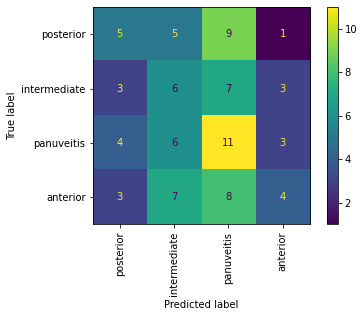

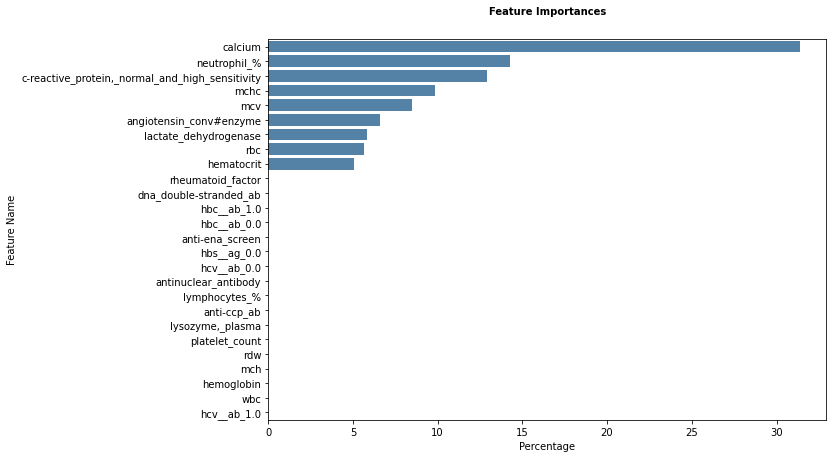

In [124]:
dec_tree(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.28082771570166526
Best Parameters:
{'tree__class_weight': None, 'tree__criterion': 'gini', 'tree__max_depth': 10, 'tree__min_samples_split': 2, 'tree__random_state': 43, 'tree__splitter': 'random'}
              precision    recall  f1-score   support

    anterior       0.40      0.17      0.24        36
intermediate       0.12      0.12      0.12        25
  panuveitis       0.30      0.52      0.38        31
   posterior       0.38      0.38      0.38        39

    accuracy                           0.31       131
   macro avg       0.30      0.30      0.28       131
weighted avg       0.32      0.31      0.29       131

Standarddeviation Score: 0.015886027376519007


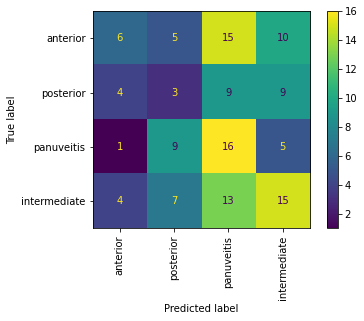

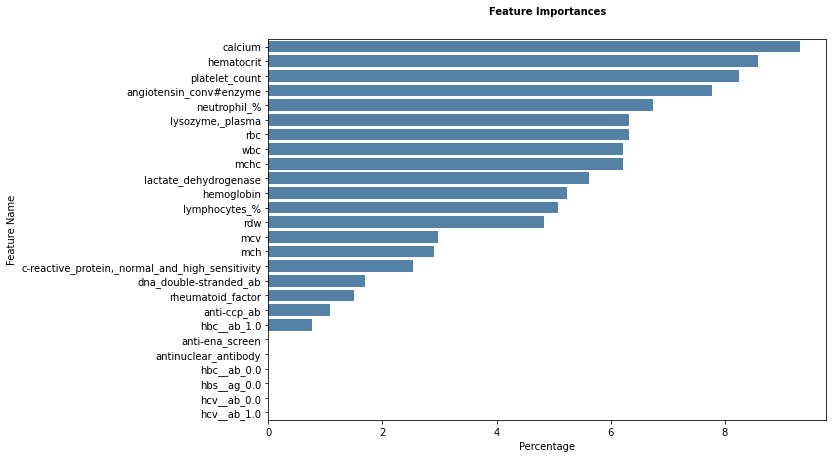

In [125]:
dec_tree(X_train_f, X_test_f, y_train_f, y_test_f)

## Random Forest
### Complete positive data

Score: 0.25239036738698545
Best Parameters:
{'tree__max_features': 'sqrt', 'tree__n_estimators': 100, 'tree__oob_score': True}
              precision    recall  f1-score   support

    anterior       0.25      0.27      0.26        56
intermediate       0.20      0.16      0.18        44
  panuveitis       0.22      0.20      0.21        55
   posterior       0.34      0.39      0.37        61

    accuracy                           0.26       216
   macro avg       0.25      0.26      0.25       216
weighted avg       0.26      0.26      0.26       216

Standarddeviation Score: 0.01843299987170987


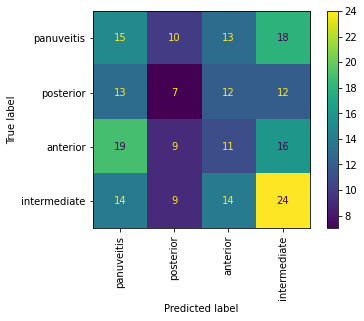

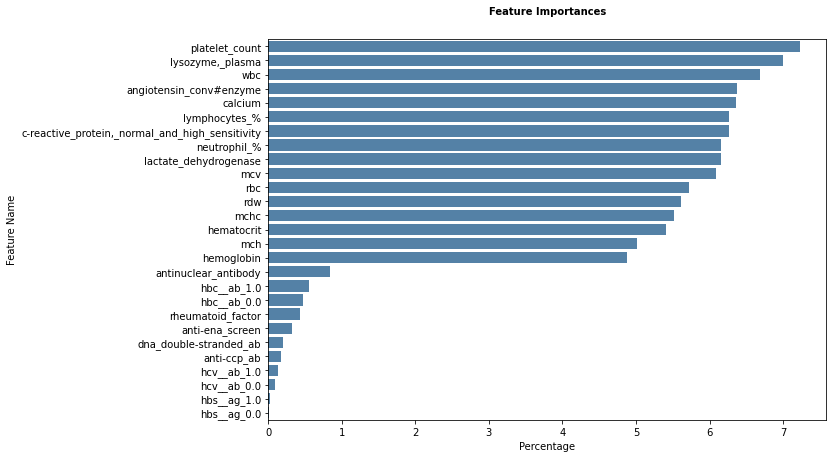

In [126]:
from sklearn.ensemble import RandomForestClassifier

def ran_tree(X_train, X_test, y_train, y_test):
    rantree = RandomForestClassifier(n_jobs=-1, random_state=RANDOM)

    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('tree', rantree)
    ])

    # hyperparameterspace
    parameters = {
        'tree__n_estimators':[100,1000],
        'tree__max_features':['log2', 'sqrt', 'auto'],
        'tree__oob_score':[True,False]
    }

    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv.best_estimator_, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    plot_featureimportance(bv.best_estimator_)

    
ran_tree(X_train, X_test, y_train, y_test)

In [19]:
# helpers.plot_validation_curve(bv.best_estimator_.fit(X_train, y_train), X_test, y_test, 'tree__n_estimators',np.arange(10,100,10), scorer)

### Male positive data

Score: 0.2394184573148197
Best Parameters:
{'tree__max_features': 'sqrt', 'tree__n_estimators': 1000, 'tree__oob_score': True}
              precision    recall  f1-score   support

    anterior       0.18      0.10      0.13        20
intermediate       0.29      0.32      0.30        19
  panuveitis       0.21      0.25      0.23        24
   posterior       0.28      0.32      0.30        22

    accuracy                           0.25        85
   macro avg       0.24      0.25      0.24        85
weighted avg       0.24      0.25      0.24        85

Standarddeviation Score: 0.06603661713128653


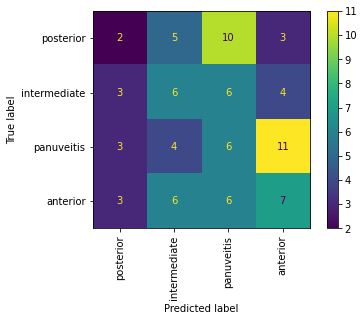

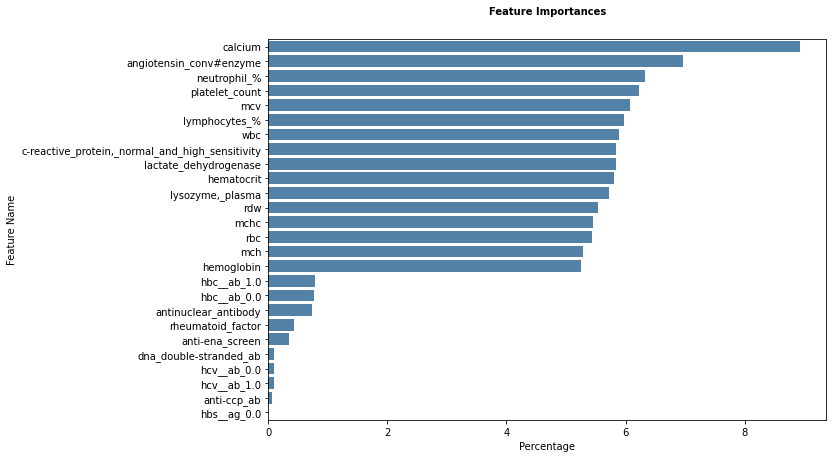

In [127]:
ran_tree(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.2770630525677444
Best Parameters:
{'tree__max_features': 'log2', 'tree__n_estimators': 1000, 'tree__oob_score': True}
              precision    recall  f1-score   support

    anterior       0.31      0.28      0.29        36
intermediate       0.20      0.12      0.15        25
  panuveitis       0.23      0.19      0.21        31
   posterior       0.38      0.56      0.45        39

    accuracy                           0.31       131
   macro avg       0.28      0.29      0.28       131
weighted avg       0.29      0.31      0.29       131

Standarddeviation Score: 0.048386284851244465


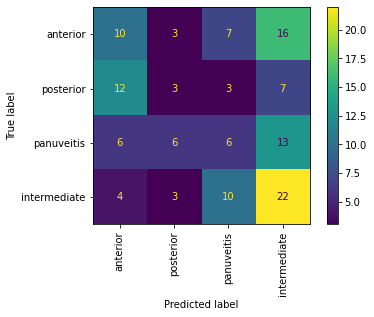

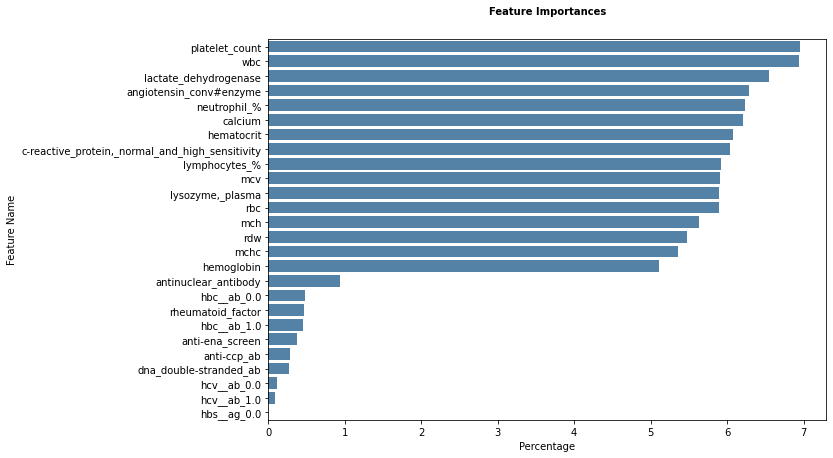

In [128]:
ran_tree(X_train_f, X_test_f, y_train_f, y_test_f)

## KNN
### Complete positive data

Score: 0.2496788783688818
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 25, 'knn__weights': 'distance'}
              precision    recall  f1-score   support

    anterior       0.22      0.18      0.20        56
intermediate       0.21      0.20      0.21        44
  panuveitis       0.30      0.24      0.26        55
   posterior       0.28      0.39      0.33        61

    accuracy                           0.26       216
   macro avg       0.25      0.25      0.25       216
weighted avg       0.26      0.26      0.25       216

Standarddeviation Score: 0.030147689346882833


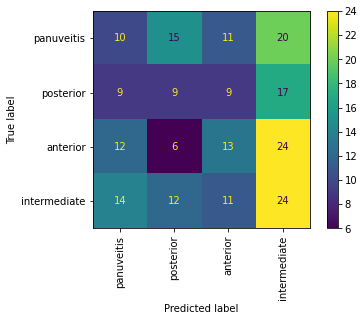

In [129]:
from sklearn.neighbors import KNeighborsClassifier

def knn_model(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier(n_jobs=-1)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('knn', knn)
    ])

    # hyperparameterspace
    parameters = {
        'knn__n_neighbors':np.arange(5,100,10),
        'knn__weights':['uniform', 'distance'],
        'knn__algorithm':['auto','ball_tree','kd_tree','brute']
    }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    

knn_model(X_train, X_test, y_train, y_test)

### Male positive data 

Score: 0.3388596424784124
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
              precision    recall  f1-score   support

    anterior       0.21      0.30      0.25        20
intermediate       0.32      0.37      0.34        19
  panuveitis       0.50      0.46      0.48        24
   posterior       0.38      0.23      0.29        22

    accuracy                           0.34        85
   macro avg       0.35      0.34      0.34        85
weighted avg       0.36      0.34      0.34        85

Standarddeviation Score: 0.013950571912621718


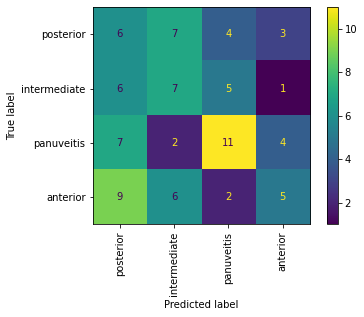

In [130]:
knn_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.3202934798423135
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 25, 'knn__weights': 'uniform'}
              precision    recall  f1-score   support

    anterior       0.32      0.53      0.40        36
intermediate       0.33      0.16      0.22        25
  panuveitis       0.38      0.19      0.26        31
   posterior       0.39      0.44      0.41        39

    accuracy                           0.35       131
   macro avg       0.35      0.33      0.32       131
weighted avg       0.36      0.35      0.33       131

Standarddeviation Score: 0.05092954598593936


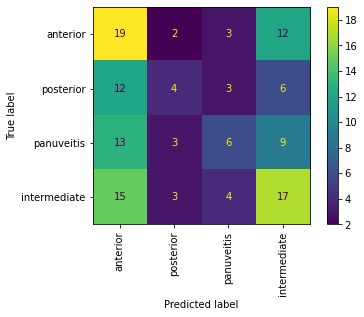

In [131]:
knn_model(X_train_f, X_test_f, y_train_f, y_test_f)

## SVM
### Complete positive data

Score: 0.23825351163634478
Best Parameters:
{'svc__C': 2.6, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

    anterior       0.20      0.14      0.17        56
intermediate       0.20      0.34      0.25        44
  panuveitis       0.24      0.24      0.24        55
   posterior       0.33      0.26      0.29        61

    accuracy                           0.24       216
   macro avg       0.24      0.25      0.24       216
weighted avg       0.25      0.24      0.24       216

Standarddeviation Score: 0.030563983613696093


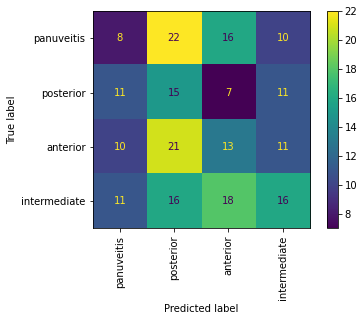

In [137]:
from sklearn.svm import SVC

def svc_model(X_train, X_test, y_train, y_test):
    svc = SVC(random_state=RANDOM)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('svc', svc)
    ])

    # hyperparameterspace
    parameters = {'svc__C':np.arange(0.1,3,.5),
                  'svc__kernel':['linear','poly','rbf','sigmoid'],
                  'svc__degree':np.arange(3,10,2), # used only for kernel = poly
                  'svc__class_weight':['balanced', None]
                 }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');

    
svc_model(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.2863483268144285
Best Parameters:
{'svc__C': 1.1, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

    anterior       0.33      0.20      0.25        20
intermediate       0.25      0.53      0.34        19
  panuveitis       0.38      0.25      0.30        24
   posterior       0.29      0.23      0.26        22

    accuracy                           0.29        85
   macro avg       0.31      0.30      0.29        85
weighted avg       0.32      0.29      0.29        85

Standarddeviation Score: 0.012744604623129891


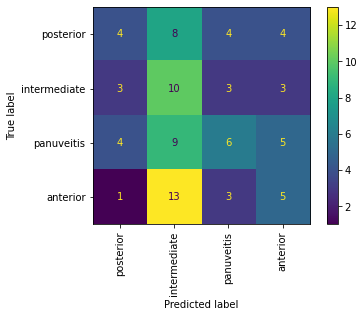

In [138]:
svc_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.28620392501178804
Best Parameters:
{'svc__C': 0.6, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'sigmoid'}
              precision    recall  f1-score   support

    anterior       0.31      0.25      0.28        36
intermediate       0.16      0.20      0.18        25
  panuveitis       0.23      0.19      0.21        31
   posterior       0.45      0.51      0.48        39

    accuracy                           0.31       131
   macro avg       0.29      0.29      0.29       131
weighted avg       0.31      0.31      0.30       131

Standarddeviation Score: 0.04832114434161707


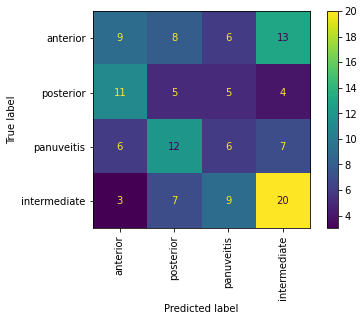

In [139]:
svc_model(X_train_f, X_test_f, y_train_f, y_test_f)

## MLP Classifier
### Complete positve data

Score: 0.24035778088938242
Best Parameters:
{'mlp__hidden_layer_sizes': (5, 5, 4)}
              precision    recall  f1-score   support

    anterior       0.29      0.43      0.35        56
intermediate       0.00      0.00      0.00        44
  panuveitis       0.22      0.18      0.20        55
   posterior       0.35      0.51      0.42        61

    accuracy                           0.30       216
   macro avg       0.22      0.28      0.24       216
weighted avg       0.23      0.30      0.26       216

Standarddeviation Score: 0.030031764425314866


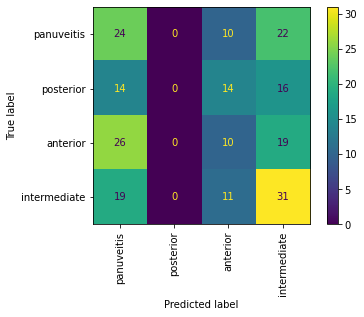

In [141]:
from sklearn.neural_network import MLPClassifier

def mlp_model(X_train, X_test, y_train, y_test):
    mlp = MLPClassifier(random_state=RANDOM)

    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('mlp', mlp)
    ])

    # hyperparameterspace
    parameters = {'mlp__hidden_layer_sizes':[(5,4),(5,5,4),(15,10),(20,20,10)]
                 }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');

    
mlp_model(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.2802621087986942
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
              precision    recall  f1-score   support

    anterior       0.29      0.30      0.29        20
intermediate       0.28      0.26      0.27        19
  panuveitis       0.31      0.33      0.32        24
   posterior       0.25      0.23      0.24        22

    accuracy                           0.28        85
   macro avg       0.28      0.28      0.28        85
weighted avg       0.28      0.28      0.28        85

Standarddeviation Score: 0.055605354844968036


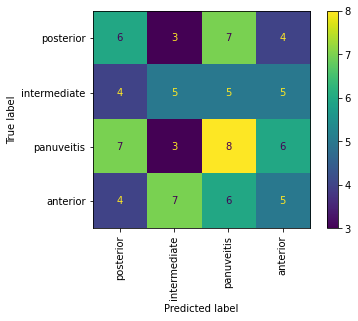

In [142]:
mlp_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.2827509133892112
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
              precision    recall  f1-score   support

    anterior       0.26      0.19      0.22        36
intermediate       0.27      0.32      0.29        25
  panuveitis       0.42      0.26      0.32        31
   posterior       0.25      0.36      0.30        39

    accuracy                           0.28       131
   macro avg       0.30      0.28      0.28       131
weighted avg       0.30      0.28      0.28       131

Standarddeviation Score: 0.004120762234795548


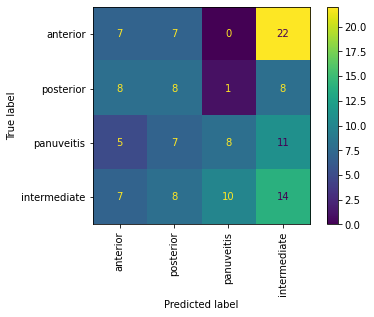

In [143]:
mlp_model(X_train_f, X_test_f, y_train_f, y_test_f)

## XGBoost
### Complete positve data

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.27506582198779767
Best Parameters:
{'xgb__colsample_bytree': 0.3, 'xgb__max_depth': 2, 'xgb__n_estimators': 15}
              precision    recall  f1-score   support

    anterior       0.31      0.30      0.31        56
intermediate       0.20      0.14      0.16        44
  panuveitis       0.29      0.35      0.31        55
   posterior       0.30      0.33      0.31        61

    accuracy                           0.29       216
   macro avg       0.28      0.28      0.28       216
weighted avg       0.28      0.29      0.28       216

Standarddeviation Score: 0.005708855735913458


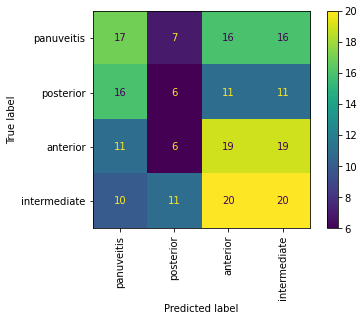

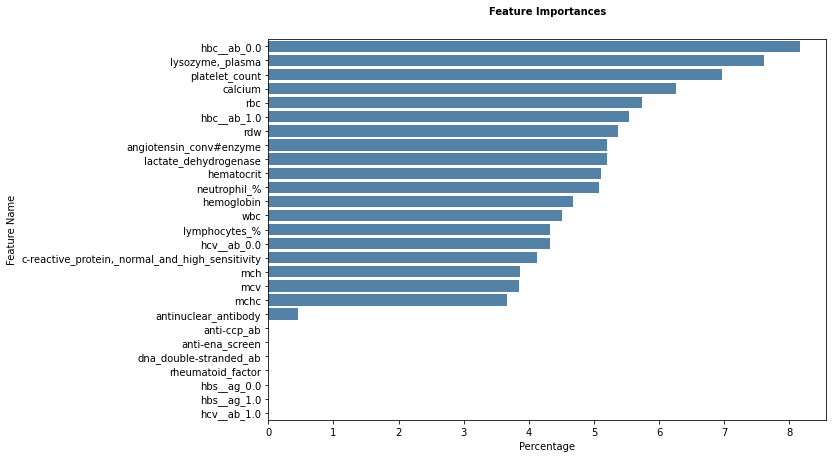

In [144]:
#!pip install xgboost
import xgboost as xgb

#dtrain_full = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
#dtest_full = xgb.DMatrix(data=X_test, label=y_test)

def xgb_model(X_train, X_test, y_train, y_test):
    params = {'xgb__colsample_bytree':[0.3,0.7,1],
             'xgb__max_depth':[2,5,7],
             'xgb__n_estimators':[10,15,20]}

    gbm = xgb.XGBClassifier(n_jobs=-1, objective='binary:logistic', random_state=RANDOM, verbosity=0)

    pipeline = Pipeline(steps=[
            ('prep', USE_IMPUTER),
            ('xgb', gbm)
        ])

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    plot_featureimportance(bv.best_estimator_)


xgb_model(X_train, X_test, y_train, y_test)

### Male positive data

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.27157203540535646
Best Parameters:
{'xgb__colsample_bytree': 0.3, 'xgb__max_depth': 2, 'xgb__n_estimators': 10}
              precision    recall  f1-score   support

    anterior       0.22      0.20      0.21        20
intermediate       0.25      0.16      0.19        19
  panuveitis       0.26      0.33      0.29        24
   posterior       0.38      0.41      0.39        22

    accuracy                           0.28        85
   macro avg       0.28      0.28      0.27        85
weighted avg       0.28      0.28      0.28        85

Standarddeviation Score: 0.05673753806554439


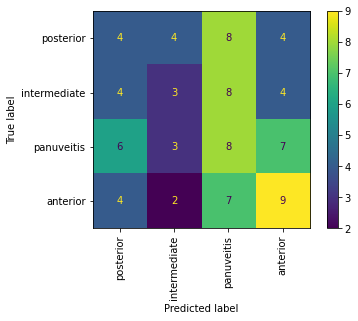

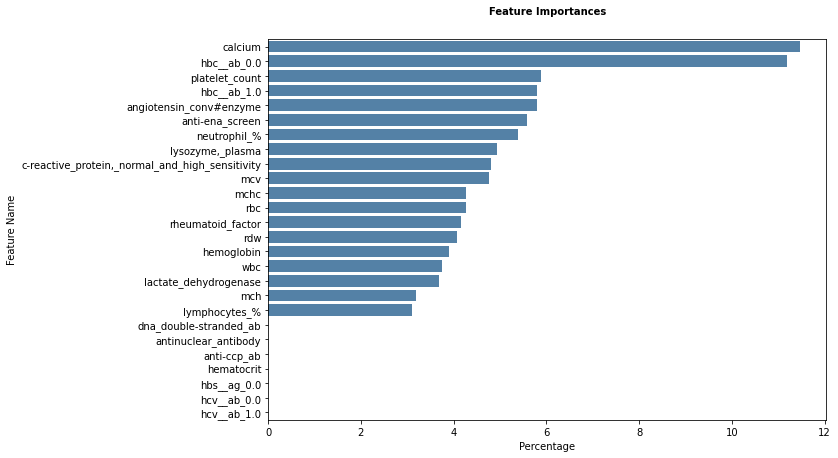

In [145]:
xgb_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.2680939337689711
Best Parameters:
{'xgb__colsample_bytree': 1, 'xgb__max_depth': 5, 'xgb__n_estimators': 15}
              precision    recall  f1-score   support

    anterior       0.35      0.31      0.33        36
intermediate       0.22      0.16      0.19        25
  panuveitis       0.17      0.16      0.17        31
   posterior       0.34      0.46      0.39        39

    accuracy                           0.29       131
   macro avg       0.27      0.27      0.27       131
weighted avg       0.28      0.29      0.28       131

Standarddeviation Score: 0.05757612467676722


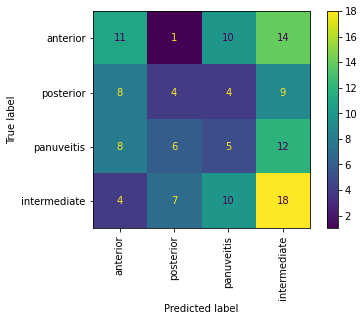

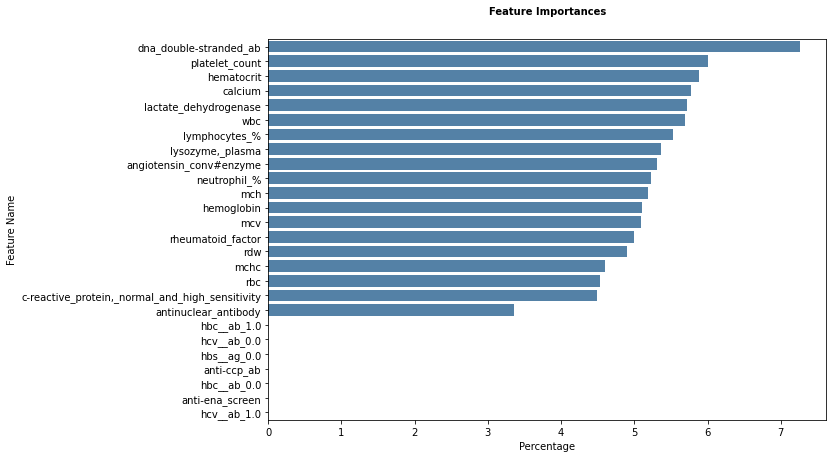

In [146]:
xgb_model(X_train_f, X_test_f, y_train_f, y_test_f)

## AdaBoost
### Complete positve data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Score: 0.27897327999566557
Best Parameters:
{'ada__base_estimator__class_weight': 'balanced', 'ada__base_estimator__criterion': 'entropy', 'ada__base_estimator__max_depth': 12, 'ada__base_estimator__min_samples_split': 12, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'best', 'ada__n_estimators': 50}
              precision    recall  f1-score   support

    anterior       0.30      0.36      0.33        56
intermediate       0.21      0.14      0.16        44
  panuveitis       0.30      0.31      0.31        55
   posterior       0.31      0.33      0.32        61

    accuracy                           0.29       216
   macro avg       0.28      0.28      0.28       216
weighted avg       0.29      0.29      0.29       216

Standarddeviation Score: 0.014376685399665273


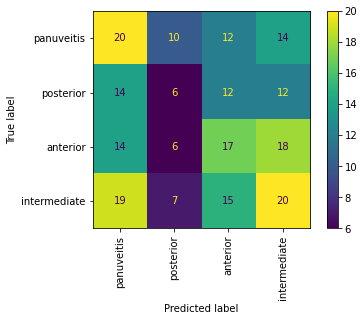

In [147]:
from sklearn.ensemble import AdaBoostClassifier

def ada_model(X_train, X_test, y_train, y_test):
    base_estimator = DecisionTreeClassifier(random_state=RANDOM)

    ada = AdaBoostClassifier(base_estimator=base_estimator, random_state=RANDOM)

    pipeline = Pipeline(steps=[
                ('prep', USE_IMPUTER),
                ('ada', ada)
            ])

    params = {'ada__base_estimator__criterion':['gini','entropy'],
            'ada__base_estimator__splitter' :['best','random'],
            'ada__base_estimator__max_depth':np.arange(2,20,2),
            'ada__base_estimator__min_samples_split':[int(i) for i in np.arange(2,20,10)],
            'ada__base_estimator__random_state':[RANDOM],
            'ada__base_estimator__class_weight':['balanced', None],
            'ada__n_estimators':[10,25,50]}

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    #plot_featureimportance(bv.best_estimator_)

    
ada_model(X_train, X_test, y_train, y_test)

### Male positive data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Score: 0.32865146058423367
Best Parameters:
{'ada__base_estimator__class_weight': None, 'ada__base_estimator__criterion': 'entropy', 'ada__base_estimator__max_depth': 14, 'ada__base_estimator__min_samples_split': 12, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'best', 'ada__n_estimators': 25}
              precision    recall  f1-score   support

    anterior       0.27      0.20      0.23        20
intermediate       0.31      0.26      0.29        19
  panuveitis       0.40      0.42      0.41        24
   posterior       0.34      0.45      0.39        22

    accuracy                           0.34        85
   macro avg       0.33      0.33      0.33        85
weighted avg       0.33      0.34      0.33        85

Standarddeviation Score: 0.05171425203164342


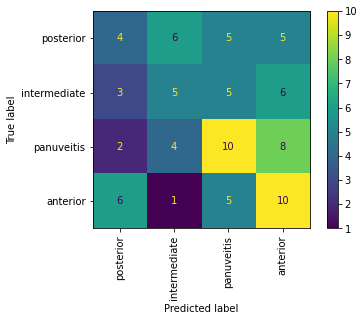

In [148]:
ada_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Score: 0.25868255038443155
Best Parameters:
{'ada__base_estimator__class_weight': None, 'ada__base_estimator__criterion': 'gini', 'ada__base_estimator__max_depth': 6, 'ada__base_estimator__min_samples_split': 12, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'best', 'ada__n_estimators': 25}
              precision    recall  f1-score   support

    anterior       0.28      0.33      0.30        36
intermediate       0.17      0.12      0.14        25
  panuveitis       0.26      0.26      0.26        31
   posterior       0.33      0.33      0.33        39

    accuracy                           0.27       131
   macro avg       0.26      0.26      0.26       131
weighted avg       0.27      0.27      0.27       131

Standarddeviation Score: 0.049862386621540515


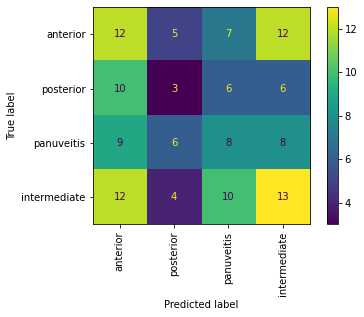

In [149]:
ada_model(X_train_f, X_test_f, y_train_f, y_test_f)

# Binary classification
In this section we try to predict the location of an inflammation of uveitis positive patients. For this we remove records of non uveitis patients.
These models can be used as a comparison for the mulitclass classification (see chapter above)

## Data Preparation
To predict the location of an inflammation, we need to drop all columns that contain information about the location. Meta-Information about the patient will also be dropped.

In [150]:
# calling preprocessing function

# num_to_cat = True: Range Date is now dtype Category 
# drop_filter: Drop every column that is not a lab test

df = pipe.preprocessing_pipe(num_to_cat   = False,
                             drop_filter  = ['hla', 'ac_', 'vit_','race', 'cat','specific_diagnosis'],
                             loc_approach = 'binary',
                             binary_cat   = True,
                             nan_percentage = 0.2,
                             hot_encode_cat = True) 
df.head()

,gender,loc,calcium,lactate_dehydrogenase,"c-reactive_protein,_normal_and_high_sensitivity",wbc,rbc,hemoglobin,hematocrit,mcv,...,"lysozyme,_plasma",anti-ccp_ab,anti-ena_screen,antinuclear_antibody,dna_double-stranded_ab,rheumatoid_factor,hbc__ab,hbs__ag,hcv__ab,uveitis
0,Male,anterior_segment,2.27,184,1.83,6.91,4.97,14.6,41.4,83.3,...,3.0,0.0,0.0,0.0,0.0,0,0,0,0,False
1,Female,posterior_segment,2.32,209,0.15,4.24,4.22,11.0,36.0,85.3,...,<NA>,0.0,0.0,0.0,0.0,0,0,0,0,True
2,Female,posterior_segment,2.44,194,0.137,6.38,4.31,13.6,38.7,89.8,...,4.8,0.0,0.0,0.0,0.0,0,0,0,0,True
3,Female,anterior_segment,2.45,156,3.5,5.24,4.82,14.6,43.6,90.5,...,<NA>,0.0,0.0,0.0,0.0,0,0,0,0,True
4,Female,anterior_segment,2.28,175,1.0,8.31,4.72,14.0,40.7,86.2,...,4.5,0.0,0.0,0.0,1.0,0,0,0,0,True


### Split into uveitis and not_uveitis data

In [151]:
df_uv_pos = df[df.uveitis == True]
df_uv_neg = df[df.uveitis != True]

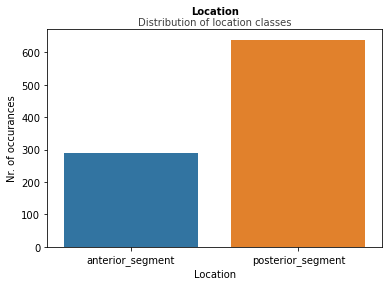

In [152]:
df_uv_pos_clean = df_uv_pos.dropna(subset=['loc']) # drop records with missing location data (3)


g = sns.countplot(x=df_uv_pos_clean['loc'])
helpers.plot_wrapper(g, 'Location','Distribution of location classes','Location','Nr. of occurances')

#### Train-Test Split
Trainingset contains 75% of data. The target feature is the loc (Location)-Feature. 
The target feature contains 3 missing values. We initially drop these records.

In [153]:
# train_test_split
X = df_uv_pos_clean.drop(columns=['loc','uveitis','gender'])
y = df_uv_pos_clean['loc']

X_m = df_uv_pos_clean[df_uv_pos_clean.gender == 'Male'].drop(columns=['loc','uveitis','gender'])
X_f = df_uv_pos_clean[df_uv_pos_clean.gender == 'Female'].drop(columns=['loc','uveitis','gender'])
y_m = df_uv_pos_clean[df_uv_pos_clean.gender == 'Male']['loc']
y_f = df_uv_pos_clean[df_uv_pos_clean.gender == 'Female']['loc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM, stratify = y)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.25, random_state=RANDOM, stratify = y_m)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.25, random_state=RANDOM, stratify = y_f)

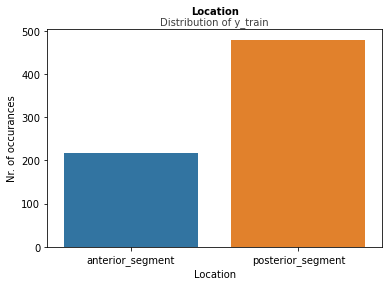

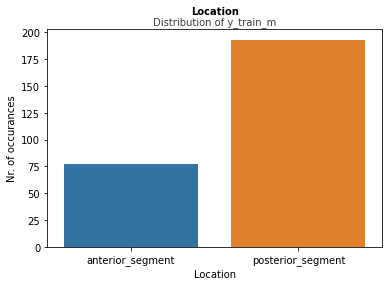

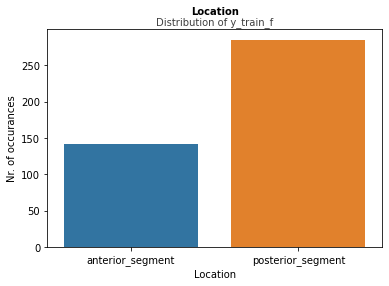

In [154]:
g = sns.countplot(x=y_train)
helpers.plot_wrapper(g, 'Location','Distribution of y_train','Location','Nr. of occurances')
g = sns.countplot(x=y_train_m)
helpers.plot_wrapper(g, 'Location','Distribution of y_train_m','Location','Nr. of occurances')
g = sns.countplot(x=y_train_f)
helpers.plot_wrapper(g, 'Location','Distribution of y_train_f','Location','Nr. of occurances')

#### Imputation and Encoding

In [155]:
# filter for numeric and categorical features
numerics = ['Int64','float64']
category = ['category','bool']

# select list of numeric and categorical features
numeric_features = X.select_dtypes(include=numerics).columns.tolist()
categorical_features = X.select_dtypes(include=category).columns.tolist()

# define imputer strategy (consult sklarn SimpleImputer and StandardScaler documentation for options)
imputer = {'categorical':{'strategy':'most_frequent','fill_value':'most_frequent'}, 'numerical':{'strategy':'median', 'fill_value':'mean'}}
imputer_encoder_no_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False)
imputer_encoder_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=False)
imputer_encoder_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=True)
imputer_encoder_no_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False, knn_impute=True)

USE_IMPUTER = imputer_encoder_onehot # imputer_encoder_onehot yields best results so far 

## 3-Dimensional Data Representation

In [156]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train.values,
                   title="PCA representation of uveitits positive training data", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 40.35 %


In [157]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_m)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_m.values,
                   title="PCA representation of uveitits positive training data (male only)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.25 %


In [158]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_f)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_f.values,
                   title="PCA representation of uveitits positive training data (female only)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.76 %


## Baseline Model
This model acts as our basline. This model takes in the prior probability of a class occuring in the trainingset, and recommends blindly based on these probabilites. 
### Complete positive data

In [159]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train, y_train)
print(f'Score Dummy Classifier: {SCORE(y_test, pipeline.predict(X_test))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.4882178576759858
Class probabilites: [0.31276901 0.68723099]


### Male positive data

In [160]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train_m, y_train_m)
print(f'Score Dummy Classifier: {SCORE(y_test_m, pipeline.predict(X_test_m))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.5153846153846153
Class probabilites: [0.28518519 0.71481481]


### Female positive data

In [161]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train_f, y_train_f)
print(f'Score Dummy Classifier: {SCORE(y_test_f, pipeline.predict(X_test_f))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.5653495440729482
Class probabilites: [0.33098592 0.66901408]


## Decision Tree

### Complete positive data

Score: 0.4688274358211914
Best Parameters:
{'tree__class_weight': 'balanced', 'tree__criterion': 'entropy', 'tree__max_depth': 12, 'tree__min_samples_split': 2, 'tree__random_state': 43, 'tree__splitter': 'random'}
                   precision    recall  f1-score   support

 anterior_segment       0.29      0.38      0.33        73
posterior_segment       0.67      0.56      0.61       160

         accuracy                           0.51       233
        macro avg       0.48      0.47      0.47       233
     weighted avg       0.55      0.51      0.52       233

Standarddeviation Score: 0.0130489824338884


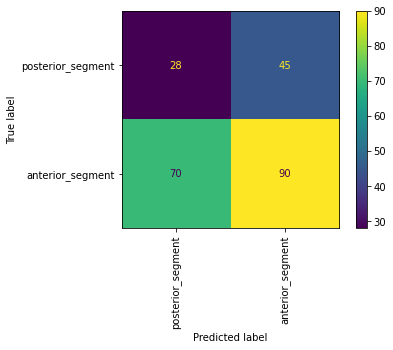

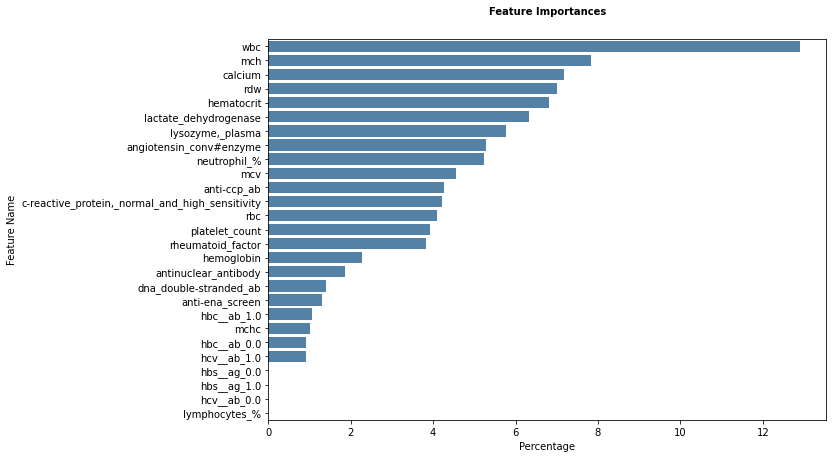

In [162]:
# supress warnings of estimator fit failed
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def dec_tree(X_train, X_test, y_train, y_test):
    dectree = DecisionTreeClassifier(random_state=RANDOM)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('tree', dectree)
    ])

    # hyperparameterspace
    parameters = {
        'tree__criterion':['gini','entropy'],
        'tree__splitter' :['best','random'],
        'tree__max_depth':np.arange(2,20,2),
        'tree__min_samples_split':[int(i) for i in np.arange(2,20,10)],
        'tree__random_state':[RANDOM],
        'tree__class_weight':['balanced', None] # balanced = inverse proportional importance per class
    }

    # grid search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');

    plot_featureimportance(bv.best_estimator_)

dec_tree(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.6406318560772268
Best Parameters:
{'tree__class_weight': None, 'tree__criterion': 'entropy', 'tree__max_depth': 10, 'tree__min_samples_split': 2, 'tree__random_state': 43, 'tree__splitter': 'best'}
                   precision    recall  f1-score   support

 anterior_segment       0.48      0.50      0.49        26
posterior_segment       0.80      0.78      0.79        65

         accuracy                           0.70        91
        macro avg       0.64      0.64      0.64        91
     weighted avg       0.71      0.70      0.70        91

Standarddeviation Score: 0.013963123165646798


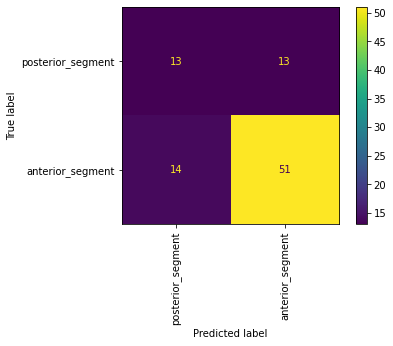

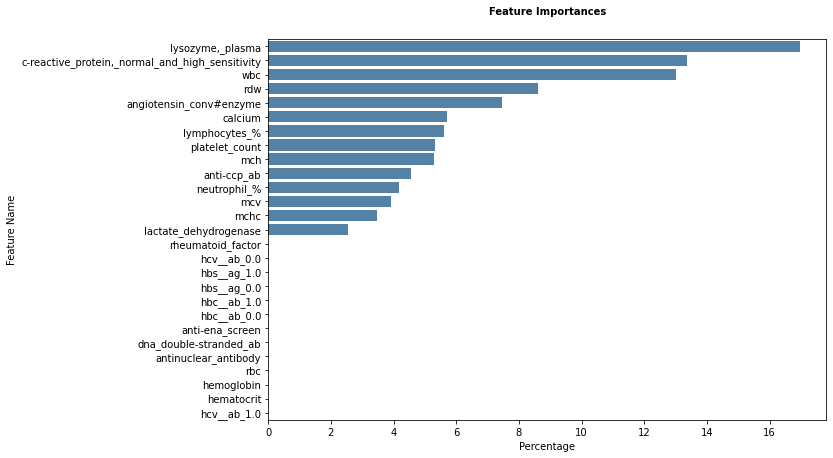

In [163]:
dec_tree(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.5009861932938856
Best Parameters:
{'tree__class_weight': 'balanced', 'tree__criterion': 'entropy', 'tree__max_depth': 16, 'tree__min_samples_split': 12, 'tree__random_state': 43, 'tree__splitter': 'random'}
                   precision    recall  f1-score   support

 anterior_segment       0.34      0.51      0.41        47
posterior_segment       0.68      0.52      0.59        96

         accuracy                           0.52       143
        macro avg       0.51      0.52      0.50       143
     weighted avg       0.57      0.52      0.53       143

Standarddeviation Score: 0.008224198056595685


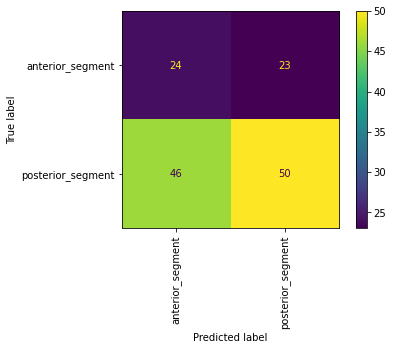

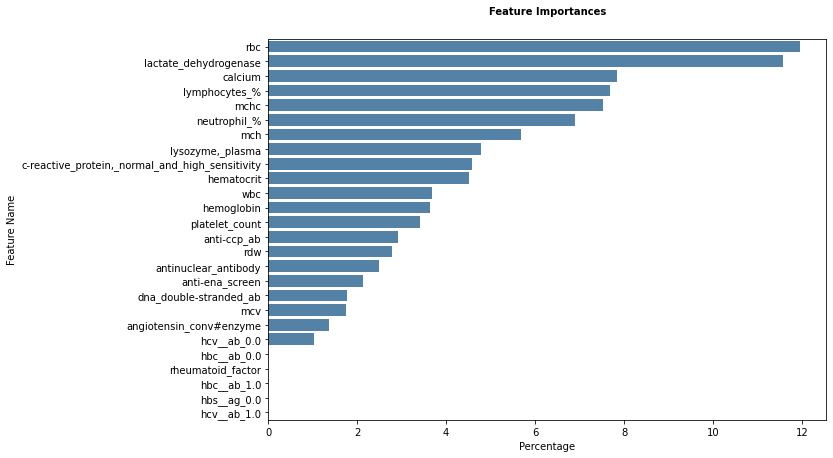

In [164]:
dec_tree(X_train_f, X_test_f, y_train_f, y_test_f)

## Random Forest
### Complete positive data

Score: 0.4524263211382114
Best Parameters:
{'tree__max_features': 'log2', 'tree__n_estimators': 100, 'tree__oob_score': True}
                   precision    recall  f1-score   support

 anterior_segment       0.44      0.05      0.10        73
posterior_segment       0.69      0.97      0.81       160

         accuracy                           0.68       233
        macro avg       0.57      0.51      0.45       233
     weighted avg       0.61      0.68      0.58       233

Standarddeviation Score: 0.024014146632159675


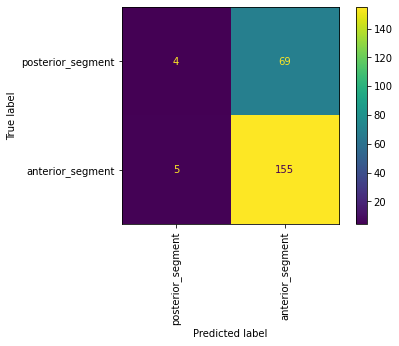

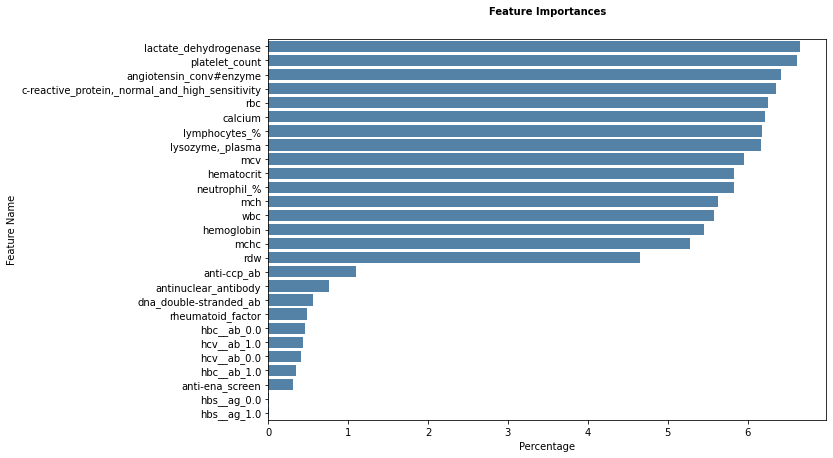

In [165]:
from sklearn.ensemble import RandomForestClassifier

def ran_tree(X_train, X_test, y_train, y_test):
    rantree = RandomForestClassifier(n_jobs=-1, random_state=RANDOM)

    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('tree', rantree)
    ])

    # hyperparameterspace
    parameters = {
        'tree__n_estimators':[100,1000],
        'tree__max_features':['log2', 'sqrt', 'auto'],
        'tree__oob_score':[True,False]
    }

    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv.best_estimator_, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    plot_featureimportance(bv.best_estimator_)


    
ran_tree(X_train, X_test, y_train, y_test)

In [166]:
# helpers.plot_validation_curve(bv.best_estimator_.fit(X_train, y_train), X_test, y_test, 'tree__n_estimators',np.arange(10,100,10), scorer)

### Male positive data

Score: 0.4574721780604134
Best Parameters:
{'tree__max_features': 'sqrt', 'tree__n_estimators': 100, 'tree__oob_score': True}
                   precision    recall  f1-score   support

 anterior_segment       0.25      0.08      0.12        26
posterior_segment       0.71      0.91      0.80        65

         accuracy                           0.67        91
        macro avg       0.48      0.49      0.46        91
     weighted avg       0.58      0.67      0.60        91

Standarddeviation Score: 0.0198577954858084


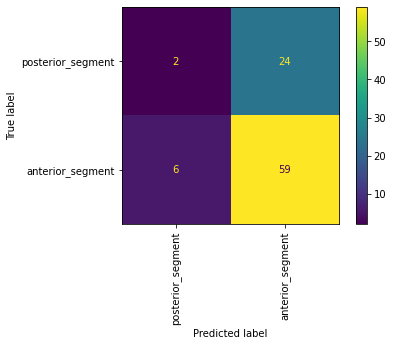

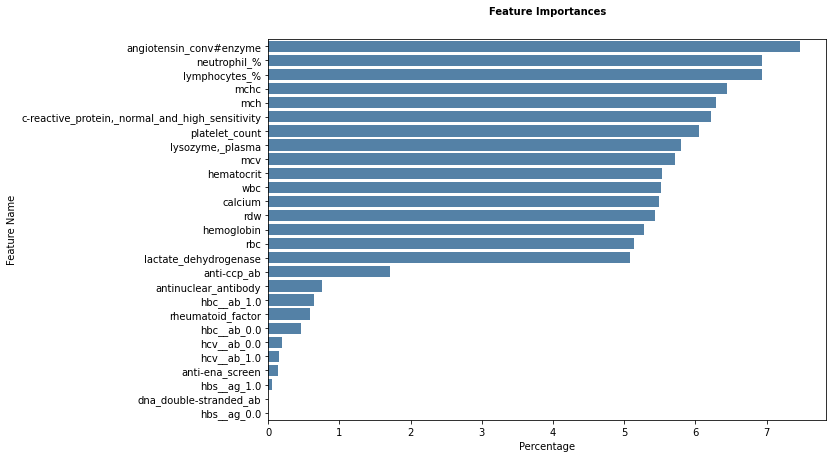

In [167]:
ran_tree(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.4851670506912442
Best Parameters:
{'tree__max_features': 'sqrt', 'tree__n_estimators': 1000, 'tree__oob_score': True}
                   precision    recall  f1-score   support

 anterior_segment       0.40      0.13      0.19        47
posterior_segment       0.68      0.91      0.78        96

         accuracy                           0.65       143
        macro avg       0.54      0.52      0.49       143
     weighted avg       0.59      0.65      0.59       143

Standarddeviation Score: 0.058754434784496025


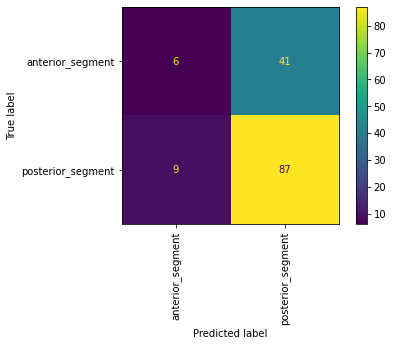

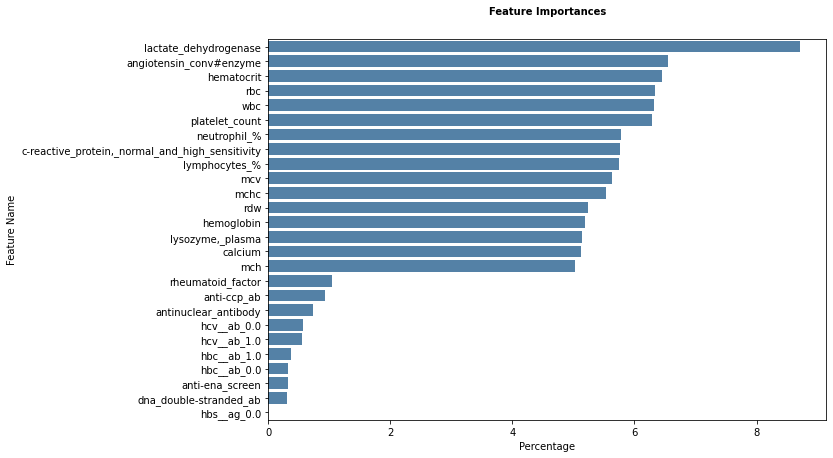

In [168]:
ran_tree(X_train_f, X_test_f, y_train_f, y_test_f)

## KNN
### Complete positive data

Score: 0.5575097019238708
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 15, 'knn__weights': 'uniform'}
                   precision    recall  f1-score   support

 anterior_segment       0.58      0.21      0.30        73
posterior_segment       0.72      0.93      0.81       160

         accuracy                           0.70       233
        macro avg       0.65      0.57      0.56       233
     weighted avg       0.68      0.70      0.65       233

Standarddeviation Score: 0.030780370887399235


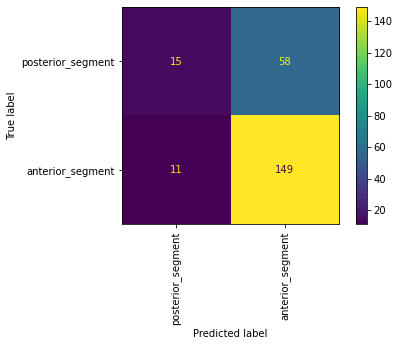

In [169]:
from sklearn.neighbors import KNeighborsClassifier

def knn_model(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier(n_jobs=-1)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('knn', knn)
    ])

    # hyperparameterspace
    parameters = {
        'knn__n_neighbors':np.arange(5,100,10),
        'knn__weights':['uniform', 'distance'],
        'knn__algorithm':['auto','ball_tree','kd_tree','brute']
    }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    

    
knn_model(X_train, X_test, y_train, y_test)

### Male positive data 

Score: 0.5357142857142856
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
                   precision    recall  f1-score   support

 anterior_segment       0.38      0.23      0.29        26
posterior_segment       0.73      0.85      0.79        65

         accuracy                           0.67        91
        macro avg       0.55      0.54      0.54        91
     weighted avg       0.63      0.67      0.64        91

Standarddeviation Score: 0.027741168200063573


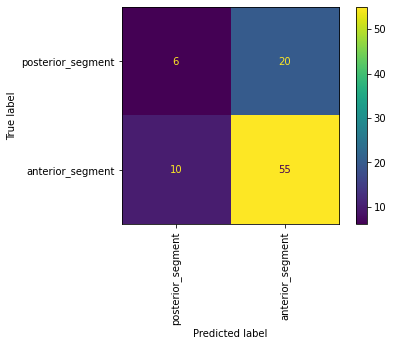

In [170]:
knn_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.4894351770558969
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
                   precision    recall  f1-score   support

 anterior_segment       0.32      0.26      0.28        47
posterior_segment       0.67      0.73      0.70        96

         accuracy                           0.57       143
        macro avg       0.49      0.49      0.49       143
     weighted avg       0.55      0.57      0.56       143

Standarddeviation Score: 0.04829919728170536


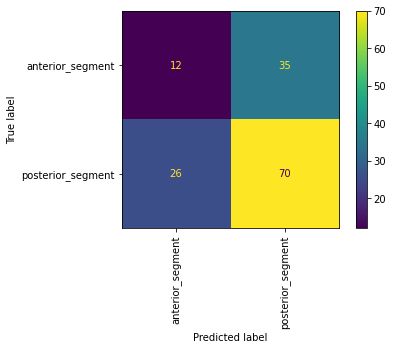

In [171]:
knn_model(X_train_f, X_test_f, y_train_f, y_test_f)

## SVM
### Complete positive data

Score: 0.49137844711913964
Best Parameters:
{'svc__C': 1.1, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'rbf'}
                   precision    recall  f1-score   support

 anterior_segment       0.31      0.40      0.35        73
posterior_segment       0.68      0.59      0.64       160

         accuracy                           0.53       233
        macro avg       0.50      0.50      0.49       233
     weighted avg       0.57      0.53      0.55       233

Standarddeviation Score: 0.027142149923553148


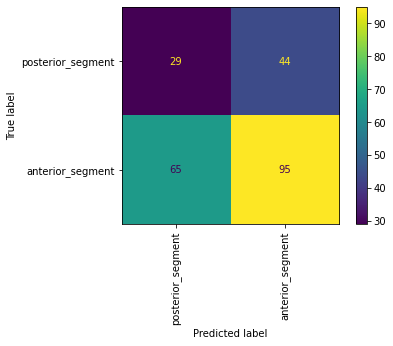

In [172]:
from sklearn.svm import SVC

def svc_model(X_train, X_test, y_train, y_test):
    svc = SVC(random_state=RANDOM)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('svc', svc)
    ])

    # hyperparameterspace
    parameters = {'svc__C':np.arange(0.1,3,.5),
                  'svc__kernel':['linear','poly','rbf','sigmoid'],
                  'svc__degree':np.arange(3,10,2), # used only for kernel = poly
                  'svc__class_weight':['balanced', None]
                 }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    

    
svc_model(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.5034894048978555
Best Parameters:
{'svc__C': 0.6, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'linear'}
                   precision    recall  f1-score   support

 anterior_segment       0.31      0.54      0.39        26
posterior_segment       0.74      0.52      0.61        65

         accuracy                           0.53        91
        macro avg       0.53      0.53      0.50        91
     weighted avg       0.62      0.53      0.55        91

Standarddeviation Score: 0.02803481349899249


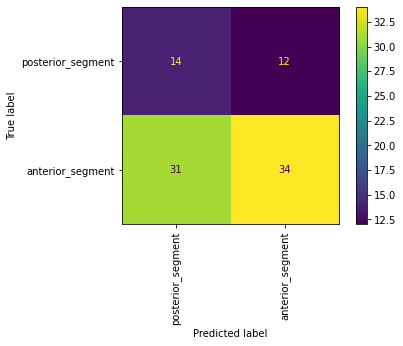

In [173]:
svc_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.5090511860174782
Best Parameters:
{'svc__C': 2.6, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'rbf'}
                   precision    recall  f1-score   support

 anterior_segment       0.34      0.45      0.39        47
posterior_segment       0.68      0.58      0.63        96

         accuracy                           0.54       143
        macro avg       0.51      0.52      0.51       143
     weighted avg       0.57      0.54      0.55       143

Standarddeviation Score: 0.01279501535883221


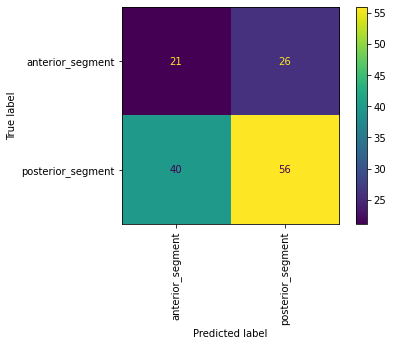

In [174]:
svc_model(X_train_f, X_test_f, y_train_f, y_test_f)

## MLP Classifier
### Complete positve data

Score: 0.5062321977896775
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
                   precision    recall  f1-score   support

 anterior_segment       0.33      0.26      0.29        73
posterior_segment       0.69      0.76      0.72       160

         accuracy                           0.60       233
        macro avg       0.51      0.51      0.51       233
     weighted avg       0.58      0.60      0.59       233

Standarddeviation Score: 0.02022286936901951


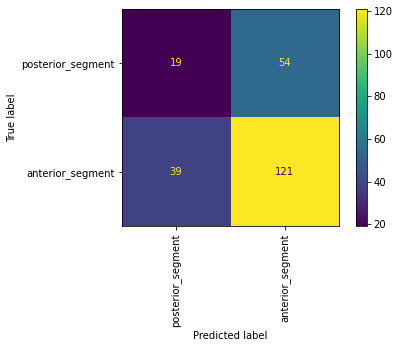

In [175]:
from sklearn.neural_network import MLPClassifier

def mlp_model(X_train, X_test, y_train, y_test):
    mlp = MLPClassifier(random_state=RANDOM)

    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('mlp', mlp)
    ])

    # hyperparameterspace
    parameters = {'mlp__hidden_layer_sizes':[(5,4),(5,5,4),(15,10),(20,20,10)]
                 }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    

    
mlp_model(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.5472636815920398
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
                   precision    recall  f1-score   support

 anterior_segment       0.36      0.31      0.33        26
posterior_segment       0.74      0.78      0.76        65

         accuracy                           0.65        91
        macro avg       0.55      0.55      0.55        91
     weighted avg       0.63      0.65      0.64        91

Standarddeviation Score: 0.04224495585255421


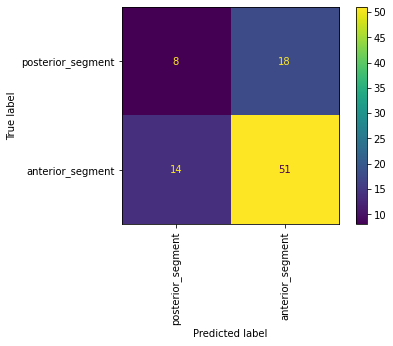

In [176]:
mlp_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.5332067184996143
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
                   precision    recall  f1-score   support

 anterior_segment       0.39      0.30      0.34        47
posterior_segment       0.69      0.77      0.73        96

         accuracy                           0.62       143
        macro avg       0.54      0.53      0.53       143
     weighted avg       0.59      0.62      0.60       143

Standarddeviation Score: 0.02345628104414958


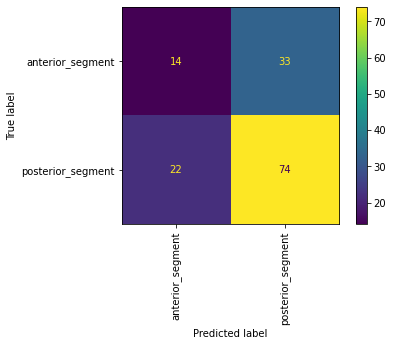

In [177]:
mlp_model(X_train_f, X_test_f, y_train_f, y_test_f)

## XGBoost
### Complete positve data

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.5365389604773847
Best Parameters:
{'xgb__colsample_bytree': 1, 'xgb__max_depth': 7, 'xgb__n_estimators': 10}
                   precision    recall  f1-score   support

 anterior_segment       0.60      0.16      0.26        73
posterior_segment       0.71      0.95      0.82       160

         accuracy                           0.70       233
        macro avg       0.66      0.56      0.54       233
     weighted avg       0.68      0.70      0.64       233

Standarddeviation Score: 0.039550722313587874


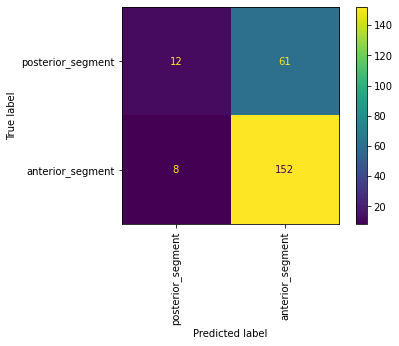

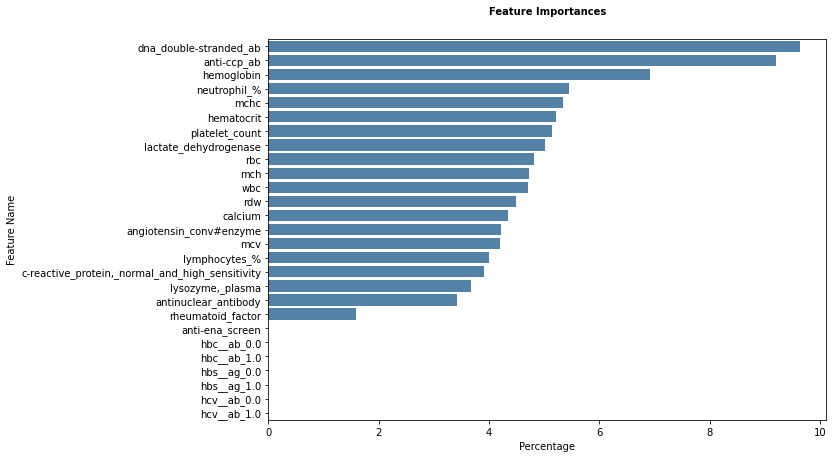

In [178]:
#!pip install xgboost
import xgboost as xgb

#dtrain_full = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
#dtest_full = xgb.DMatrix(data=X_test, label=y_test)

def xgb_model(X_train, X_test, y_train, y_test):
    params = {'xgb__colsample_bytree':[0.3,0.7,1],
             'xgb__max_depth':[2,5,7],
             'xgb__n_estimators':[10,15,20]}

    gbm = xgb.XGBClassifier(n_jobs=-1, objective='binary:logistic', random_state=RANDOM, verbosity=0)

    pipeline = Pipeline(steps=[
            ('prep', USE_IMPUTER),
            ('xgb', gbm)
        ])

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1, scoring=SCORER)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    plot_featureimportance(bv.best_estimator_)

xgb_model(X_train, X_test, y_train, y_test)

### Male positive data

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.48707482993197276
Best Parameters:
{'xgb__colsample_bytree': 1, 'xgb__max_depth': 5, 'xgb__n_estimators': 20}
                   precision    recall  f1-score   support

 anterior_segment       0.33      0.12      0.17        26
posterior_segment       0.72      0.91      0.80        65

         accuracy                           0.68        91
        macro avg       0.53      0.51      0.49        91
     weighted avg       0.61      0.68      0.62        91

Standarddeviation Score: 0.01570871223609797


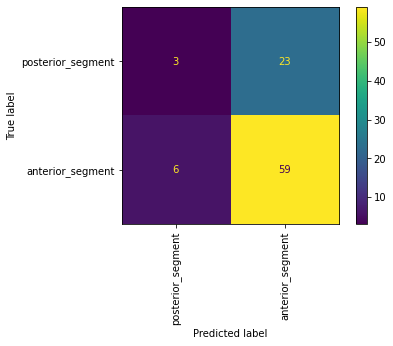

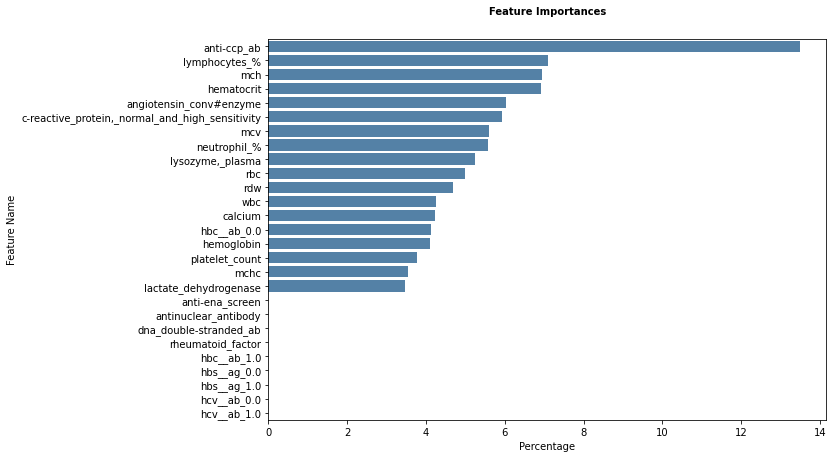

In [179]:
xgb_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.5077766445690974
Best Parameters:
{'xgb__colsample_bytree': 0.7, 'xgb__max_depth': 7, 'xgb__n_estimators': 15}
                   precision    recall  f1-score   support

 anterior_segment       0.37      0.21      0.27        47
posterior_segment       0.68      0.82      0.75        96

         accuracy                           0.62       143
        macro avg       0.53      0.52      0.51       143
     weighted avg       0.58      0.62      0.59       143

Standarddeviation Score: 0.037528273418420986


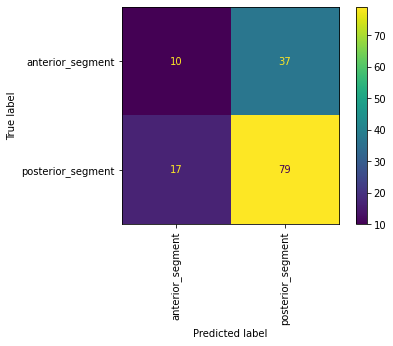

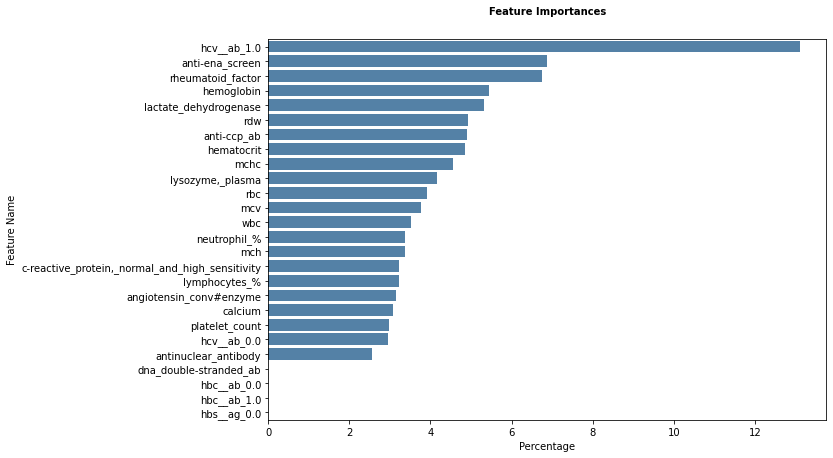

In [180]:
xgb_model(X_train_f, X_test_f, y_train_f, y_test_f)

## AdaBoost
### Complete positve data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Score: 0.5214997988694345
Best Parameters:
{'ada__base_estimator__class_weight': 'balanced', 'ada__base_estimator__criterion': 'entropy', 'ada__base_estimator__max_depth': 4, 'ada__base_estimator__min_samples_split': 12, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'random', 'ada__n_estimators': 25}
                   precision    recall  f1-score   support

 anterior_segment       0.34      0.36      0.35        73
posterior_segment       0.70      0.69      0.69       160

         accuracy                           0.58       233
        macro avg       0.52      0.52      0.52       233
     weighted avg       0.59      0.58      0.59       233

Standarddeviation Score: 0.0311931135779306


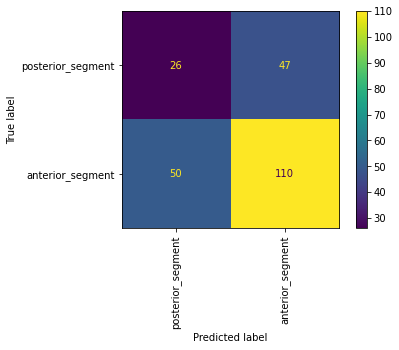

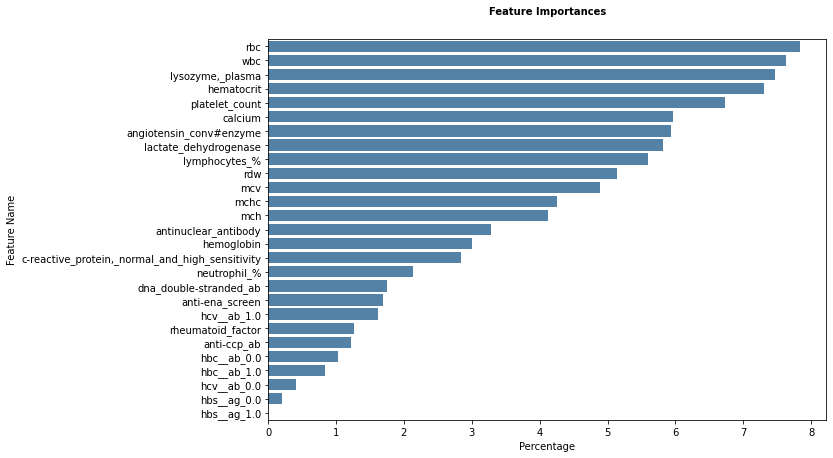

In [182]:
from sklearn.ensemble import AdaBoostClassifier

def ada_model(X_train, X_test, y_train, y_test):
    base_estimator = DecisionTreeClassifier(random_state=RANDOM)

    ada = AdaBoostClassifier(base_estimator=base_estimator, random_state=RANDOM)

    pipeline = Pipeline(steps=[
                ('prep', USE_IMPUTER),
                ('ada', ada)
            ])

    params = {'ada__base_estimator__criterion':['gini','entropy'],
            'ada__base_estimator__splitter' :['best','random'],
            'ada__base_estimator__max_depth':np.arange(2,20,2),
            'ada__base_estimator__min_samples_split':[int(i) for i in np.arange(2,20,10)],
            'ada__base_estimator__random_state':[RANDOM],
            'ada__base_estimator__class_weight':['balanced', None],
            'ada__n_estimators':[10,25,50]}

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1, scoring=SCORER)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    plot_featureimportance(bv.best_estimator_)

ada_model(X_train, X_test, y_train, y_test)

### Male positive data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Score: 0.5523726851851851
Best Parameters:
{'ada__base_estimator__class_weight': None, 'ada__base_estimator__criterion': 'gini', 'ada__base_estimator__max_depth': 18, 'ada__base_estimator__min_samples_split': 2, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'random', 'ada__n_estimators': 10}
                   precision    recall  f1-score   support

 anterior_segment       0.36      0.38      0.37        26
posterior_segment       0.75      0.72      0.73        65

         accuracy                           0.63        91
        macro avg       0.55      0.55      0.55        91
     weighted avg       0.63      0.63      0.63        91

Standarddeviation Score: 0.03692799235925873


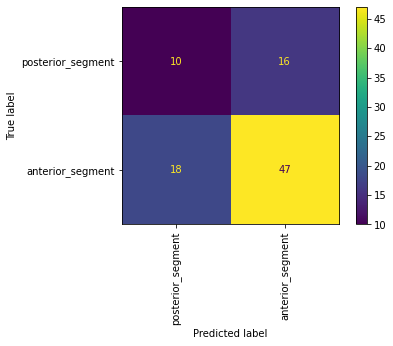

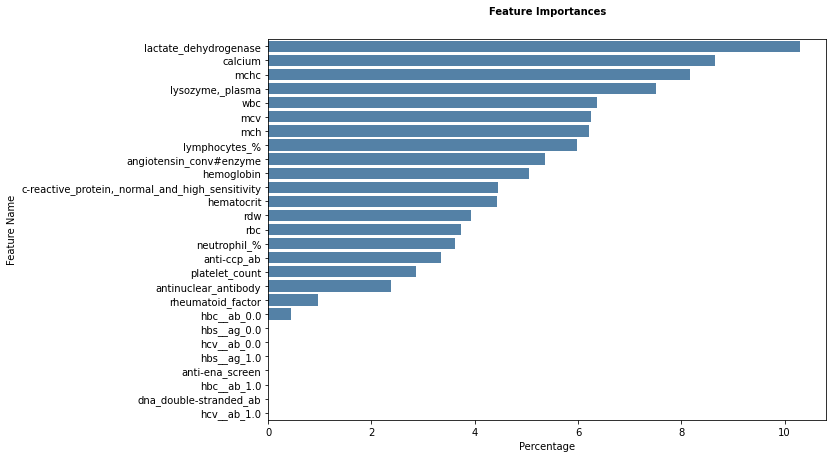

In [183]:
ada_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Score: 0.4579630895420369
Best Parameters:
{'ada__base_estimator__class_weight': 'balanced', 'ada__base_estimator__criterion': 'gini', 'ada__base_estimator__max_depth': 14, 'ada__base_estimator__min_samples_split': 2, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'random', 'ada__n_estimators': 10}
                   precision    recall  f1-score   support

 anterior_segment       0.27      0.17      0.21        47
posterior_segment       0.65      0.77      0.71        96

         accuracy                           0.57       143
        macro avg       0.46      0.47      0.46       143
     weighted avg       0.53      0.57      0.54       143

Standarddeviation Score: 0.003940245407330828


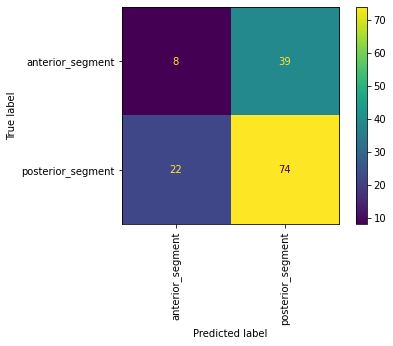

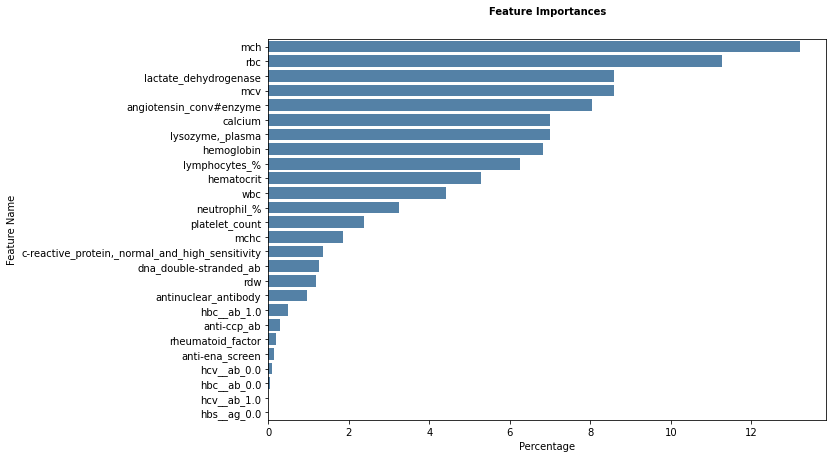

In [184]:
ada_model(X_train_f, X_test_f, y_train_f, y_test_f)

# One vs. All Location Prediction
In this section we try to identify importent lab tests for a location. For this train a model for every single location and mask every other location as "other". For easy interpretability and feature extraction we restrain ourselfs to tree based algorithmns.

## Data Preparation
To predict the location of an inflammation, we need to drop all columns that contain information about the location. Meta-Information about the patient will also be dropped.

In [185]:
# calling preprocessing function

# num_to_cat = True: Range Date is now dtype Category 
# drop_filter: Drop every column that is not a lab test

df = pipe.preprocessing_pipe(num_to_cat   = False,
                             drop_filter  = ['hla', 'ac_', 'vit_','race', 'cat','specific_diagnosis'],
                             loc_approach = 'multi',
                             binary_cat   = True,
                             nan_percentage = 0.2,
                             hot_encode_cat = True) 
df.head()

,gender,loc,calcium,lactate_dehydrogenase,"c-reactive_protein,_normal_and_high_sensitivity",wbc,rbc,hemoglobin,hematocrit,mcv,...,"lysozyme,_plasma",anti-ccp_ab,anti-ena_screen,antinuclear_antibody,dna_double-stranded_ab,rheumatoid_factor,hbc__ab,hbs__ag,hcv__ab,uveitis
0,Male,anterior,2.27,184,1.83,6.91,4.97,14.6,41.4,83.3,...,3.0,0.0,0.0,0.0,0.0,0,0,0,0,False
1,Female,intermediate,2.32,209,0.15,4.24,4.22,11.0,36.0,85.3,...,<NA>,0.0,0.0,0.0,0.0,0,0,0,0,True
2,Female,panuveitis,2.44,194,0.137,6.38,4.31,13.6,38.7,89.8,...,4.8,0.0,0.0,0.0,0.0,0,0,0,0,True
3,Female,anterior,2.45,156,3.5,5.24,4.82,14.6,43.6,90.5,...,<NA>,0.0,0.0,0.0,0.0,0,0,0,0,True
4,Female,anterior,2.28,175,1.0,8.31,4.72,14.0,40.7,86.2,...,4.5,0.0,0.0,0.0,1.0,0,0,0,0,True


### Split into uveitis and not_uveitis data

In [186]:
df_uv_pos = df[df.uveitis == True]
df_uv_neg = df[df.uveitis != True]

In [187]:
def df_one_loc(df, i):
    df_one_vs_all = df.copy()
    df_one_vs_all['loc'] = np.where(df['loc'] != i, "other", df_uv_pos['loc'])
    return df_one_vs_all

df_pos_anterior = df_one_loc(df_uv_pos, 'anterior')
df_pos_intermediate = df_one_loc(df_uv_pos, 'intermediate')
df_pos_panuveitis = df_one_loc(df_uv_pos, 'panuveitis')
df_pos_posterior = df_one_loc(df_uv_pos, 'posterior')
df_pos_scleritis = df_one_loc(df_uv_pos, 'scleritis')

#### Train Test Split

In [188]:
def split_one_loc(df):
    X = df.drop(columns=['loc','uveitis','gender'])
    y = df['loc']
    return train_test_split(X, y, test_size=0.25, random_state=RANDOM, stratify = y)

X_train_anterior, X_test_anterior, y_train_anterior, y_test_anterior = split_one_loc(df_pos_anterior)
X_train_intermediate, X_test_intermediate, y_train_intermediate, y_test_intermediate = split_one_loc(df_pos_intermediate)
X_train_panuveitis, X_test_panuveitis, y_train_panuveitis, y_test_panuveitis = split_one_loc(df_pos_panuveitis)
X_train_posterior, X_test_posterior, y_train_posterior, y_test_posterior = split_one_loc(df_pos_posterior)
X_train_scleritis, X_test_scleritis, y_train_scleritis, y_test_scleritis = split_one_loc(df_pos_scleritis)

In [189]:
X_train_anterior.hbc__ab.unique()

[0, 1, NaN]
Categories (2, int64): [0, 1]

#### Imputation and Encoding

In [190]:
# filter for numeric and categorical features
numerics = ['Int64','float64']
category = ['category','bool', 'object']

# select list of numeric and categorical features
numeric_features = X.select_dtypes(include=numerics).columns.tolist()
categorical_features = X.select_dtypes(include=category).columns.tolist()

# define imputer strategy (consult sklarn SimpleImputer and StandardScaler documentation for options)
imputer = {'categorical':{'strategy':'most_frequent','fill_value':'most_frequent'}, 'numerical':{'strategy':'median', 'fill_value':'mean'}}
imputer_encoder_no_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False)
imputer_encoder_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=False)
imputer_encoder_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=True)
imputer_encoder_no_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False, knn_impute=True)

USE_IMPUTER = imputer_encoder_onehot # imputer_encoder_onehot yields best results so far 

## 3-Dimensional Data Representation

In [191]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_anterior)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_anterior.values,
                   title="PCA representation of uveitits positive training data (Anterior vs. all)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 40.13 %


In [192]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_intermediate)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_intermediate.values,
                   title="PCA representation of uveitits positive training data (Intermediate vs. all)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.77 %


In [193]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_panuveitis)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_panuveitis.values,
                   title="PCA representation of uveitits positive training data (panuveitis vs. all)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 40.22 %


In [194]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_posterior)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_posterior.values,
                   title="PCA representation of uveitits positive training data (posterior vs. all)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.61 %


In [195]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_scleritis)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_scleritis.values,
                   title="PCA representation of uveitits positive training data (Anterior vs. all)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 40.02 %


## XGBoost

<AxesSubplot:xlabel='loc', ylabel='count'>

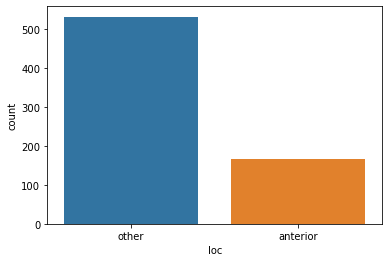

In [196]:
sns.countplot(x=y_train_anterior)

In [197]:
lab = LabelEncoder()
y_train_anterior_enc, y_test_anterior_enc = lab.fit_transform(y_train_anterior), lab.transform(y_test_anterior)
y_train_intermediate_enc, y_test_intermediate_enc = lab.fit_transform(y_train_intermediate), lab.transform(y_test_intermediate)
y_train_panuveitis_enc, y_test_panuveitis_enc = lab.fit_transform(y_train_panuveitis), lab.transform(y_test_panuveitis)
y_train_posterior_enc, y_test_posterior_enc = lab.fit_transform(y_train_posterior), lab.transform(y_test_posterior)
y_train_scleritis_enc, y_test_scleritis_enc = lab.fit_transform(y_train_scleritis), lab.transform(y_test_scleritis)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Score: 0.4372208436724566
Best Parameters:
{'xgb__colsample_bytree': 0.7, 'xgb__max_depth': 7, 'xgb__n_estimators': 10}
              precision    recall  f1-score   support

           0       0.11      0.02      0.03        56
           1       0.76      0.96      0.84       178

    accuracy                           0.73       234
   macro avg       0.43      0.49      0.44       234
weighted avg       0.60      0.73      0.65       234

Standarddeviation Score: 0.008384420763979755


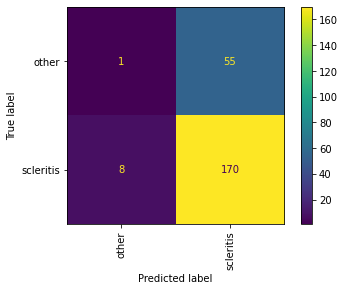

In [198]:
#!pip install xgboost
import xgboost as xgb

#dtrain_full = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
#dtest_full = xgb.DMatrix(data=X_test, label=y_test)

def xgb_model(X_train, X_test, y_train, y_test):
    params = {'xgb__colsample_bytree':[0.3,0.7,1],
             'xgb__max_depth':[2,5,7],
             'xgb__n_estimators':[10,15,20,40,60]}

    gbm = xgb.XGBClassifier(n_jobs=-1, objective='binary:logistic', random_state=RANDOM, verbosity=0, use_label_encoder=False)

    pipeline = Pipeline(steps=[
            ('prep', USE_IMPUTER),
            ('xgb', gbm)
        ])

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1, scoring=SCORER)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=lab.classes_,
                          xticks_rotation='vertical');
    
    return bv.best_estimator_
    
xgb_anterior = xgb_model(X_train_anterior, X_test_anterior, y_train_anterior_enc, y_test_anterior_enc)

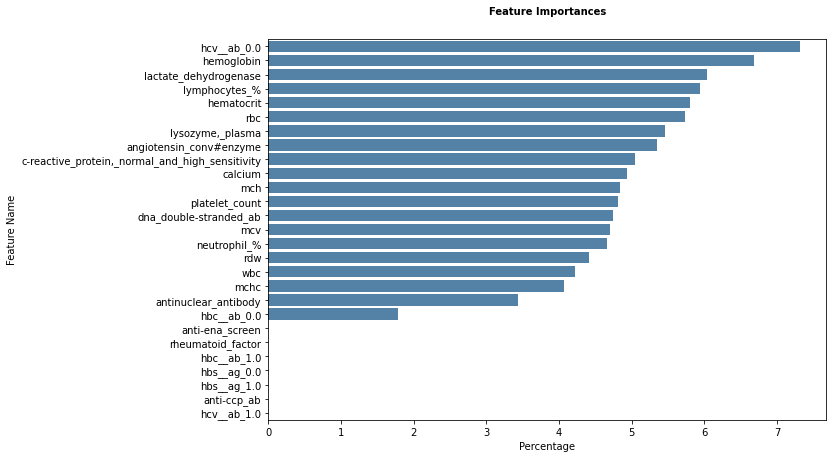

In [199]:
plot_featureimportance(xgb_anterior)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Score: 0.4686291000841043
Best Parameters:
{'xgb__colsample_bytree': 0.7, 'xgb__max_depth': 7, 'xgb__n_estimators': 60}
              precision    recall  f1-score   support

           0       0.14      0.05      0.07        44
           1       0.81      0.94      0.87       190

    accuracy                           0.77       234
   macro avg       0.48      0.49      0.47       234
weighted avg       0.68      0.77      0.72       234

Standarddeviation Score: 0.04769622843076972


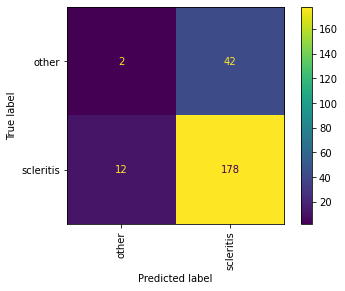

In [200]:
xgb_intermediate = xgb_model(X_train_intermediate, X_test_intermediate, y_train_intermediate_enc, y_test_intermediate_enc)

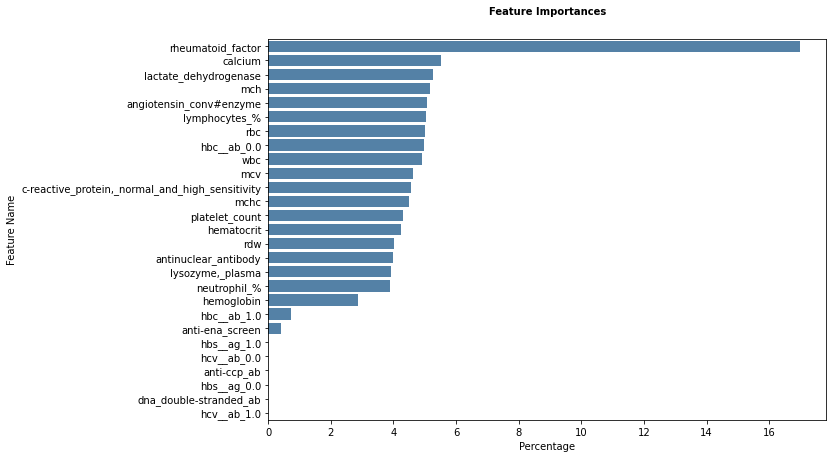

In [201]:
plot_featureimportance(xgb_intermediate)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Score: 0.4849267872523686
Best Parameters:
{'xgb__colsample_bytree': 1, 'xgb__max_depth': 5, 'xgb__n_estimators': 60}
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       179
           1       0.23      0.11      0.15        55

    accuracy                           0.71       234
   macro avg       0.50      0.50      0.48       234
weighted avg       0.64      0.71      0.66       234

Standarddeviation Score: 0.032064185784944146


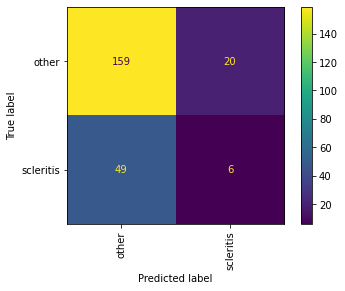

In [202]:
xgb_panuveitis = xgb_model(X_train_panuveitis, X_test_panuveitis, y_train_panuveitis_enc, y_test_panuveitis_enc)

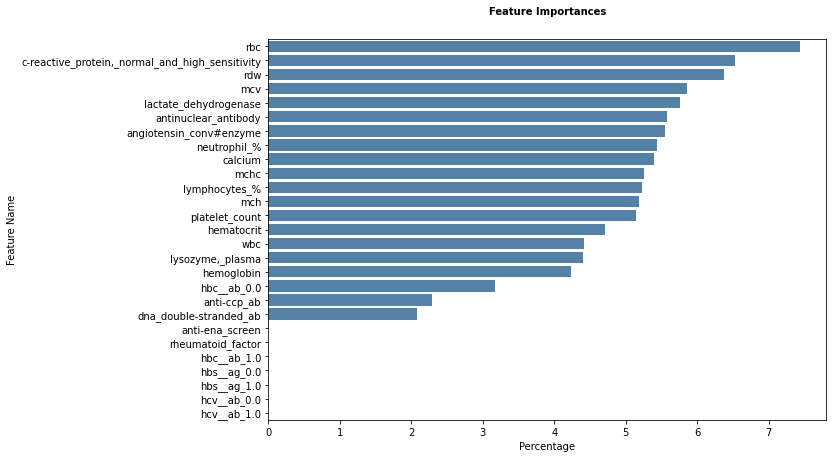

In [203]:
plot_featureimportance(xgb_panuveitis)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Score: 0.5240181505241747
Best Parameters:
{'xgb__colsample_bytree': 0.7, 'xgb__max_depth': 5, 'xgb__n_estimators': 40}
              precision    recall  f1-score   support

           0       0.75      0.92      0.83       173
           1       0.41      0.15      0.22        61

    accuracy                           0.72       234
   macro avg       0.58      0.54      0.52       234
weighted avg       0.66      0.72      0.67       234

Standarddeviation Score: 0.023848193610468034


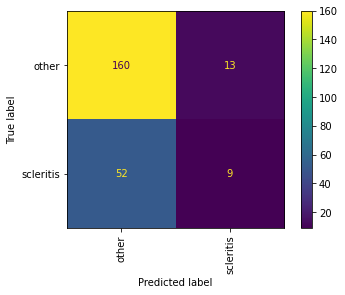

In [204]:
xgb_posterior = xgb_model(X_train_posterior, X_test_posterior, y_train_posterior_enc, y_test_posterior_enc)

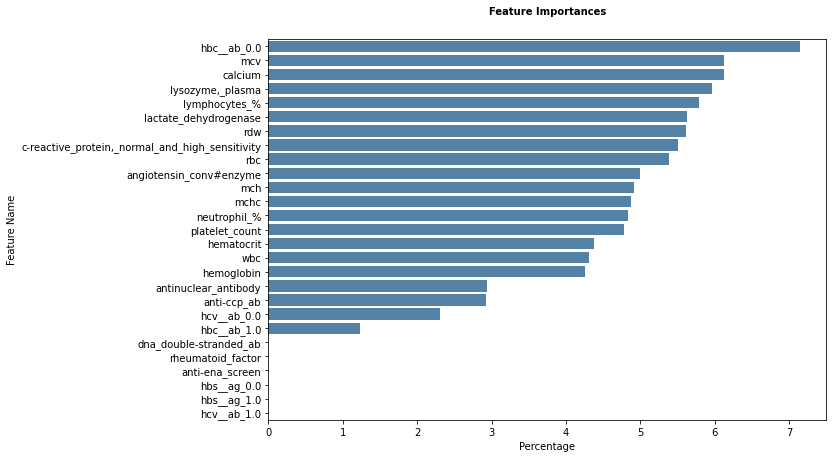

In [205]:
plot_featureimportance(xgb_posterior)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Score: 0.4811529933481153
Best Parameters:
{'xgb__colsample_bytree': 1, 'xgb__max_depth': 7, 'xgb__n_estimators': 15}
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       217
           1       0.00      0.00      0.00        17

    accuracy                           0.93       234
   macro avg       0.46      0.50      0.48       234
weighted avg       0.86      0.93      0.89       234

Standarddeviation Score: 0.04133174433168963


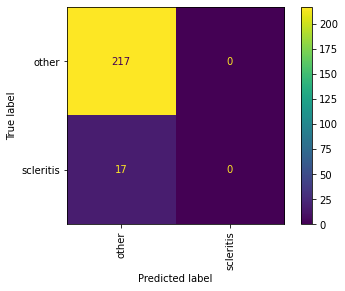

In [206]:
xgb_scleritis = xgb_model(X_train_scleritis, X_test_scleritis, y_train_scleritis_enc, y_test_scleritis_enc)

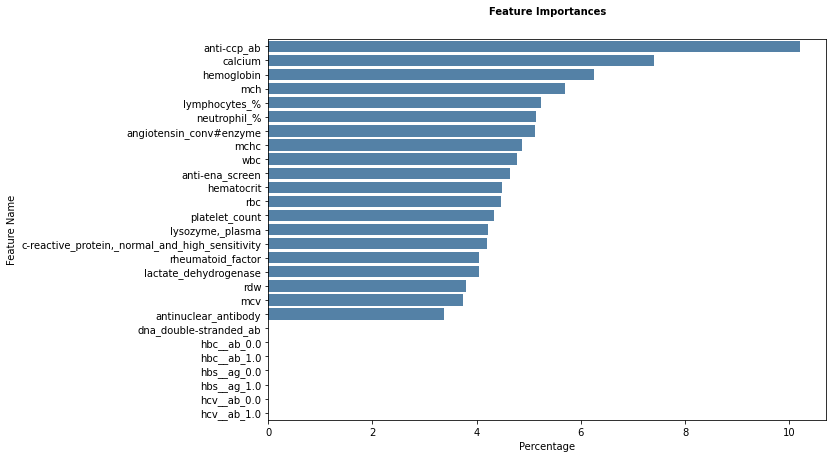

In [207]:
plot_featureimportance(xgb_scleritis)